In [1]:
import pandas as pd 


# Analyizing cross-validation + effect size models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

data_path = './data/hpo_analysis/wandb_export_2025-03-03T07_49_37.930-05_00.csv'
df = pd.read_csv(data_path)
test_columns = [col for col in df.columns if 'Default_default' in col]
print(test_columns)
# only get the rows where the test_columns are not nan
print(f'Number of rows before filtering: {len(df)}')
df = df.loc[df[test_columns[0]].notna()]
print(f'Number of rows after filtering: {len(df)}')


['Default_default_final_rel_rmse_f', 'Default_default_final_rmse_e_per_atom', 'Default_default_final_rmse_f']
Number of rows before filtering: 150
Number of rows after filtering: 150


In [3]:
test_columns = [col for col in df.columns if 'Default_default' in col]
print(test_columns)


['Default_default_final_rel_rmse_f', 'Default_default_final_rmse_e_per_atom', 'Default_default_final_rmse_f']


In [9]:
print(df.columns)

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'batch_size', 'correlation', 'energy_weight', 'forces_weight', 'lr',
       'max_L', 'max_num_epochs', 'num_channels', 'start_swa', 'swa_lr',
       'weight_decay', 'Default_default_final_rel_rmse_f',
       'Default_default_final_rmse_e_per_atom', 'Default_default_final_rmse_f',
       'default.epoch', 'default.valid_loss', 'default.valid_rmse_e_per_atom',
       'default.valid_rmse_f', 'params', 'train_default_final_rel_rmse_f',
       'train_default_final_rmse_e_per_atom', 'train_default_final_rmse_f',
       'valid_default_final_rel_rmse_f', 'valid_default_final_rmse_e_per_atom',
       'valid_default_final_rmse_f'],
      dtype='object')


In [5]:
df.iloc[0]['Name']

'model_6_r_cut5.0_max_L0_num_channels64_learning_rate0.001_batch_size4_initial_rep_4_fold_2'

In [8]:
import json
row_0_dict = json.loads(df.iloc[0]['params'])
print(row_0_dict['seed'])
print(row_0_dict['name'])
print(df.iloc[0]['Default_default_final_rmse_f'])
print(df.iloc[0]['Default_default_final_rel_rmse_f'])
print(df.iloc[0]['Runtime'])

4
model_6_r_cut5.0_max_L0_num_channels64_learning_rate0.001_batch_size4_initial_rep_4_fold_2
34.908462315797806
42.290457780606346
22871


In [10]:
import json
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import itertools
import statsmodels.stats.power as smp


def group_model_data(df):
    """Groups model data and calculates statistics, including p-values and power."""

    grouped_data = defaultdict(lambda: {"seeds": [], "rmse_f": [], "rel_rmse_f": [], "runtimes": []})

    for i in range(len(df)):
        row_dict = json.loads(df.iloc[i]['params'])
        full_name = row_dict['name']
        seed = row_dict['seed']
        base_name = full_name.split('_r_cut')[0]

        grouped_data[base_name]["seeds"].append(int(seed))
        grouped_data[base_name]["rmse_f"].append(float(df.iloc[i]['Default_default_final_rmse_f']))
        grouped_data[base_name]["rel_rmse_f"].append(float(df.iloc[i]['Default_default_final_rel_rmse_f']))
        grouped_data[base_name]["runtimes"].append(int(df.iloc[i]['Runtime']))

    # Calculate statistics and p-values
    results = {}
    model_names = list(grouped_data.keys())

    for base_name, data in grouped_data.items():
        results[base_name] = {
            "rmse_f_mean": np.mean(data["rmse_f"]),
            "rmse_f_std": np.std(data["rmse_f"]),
            "rel_rmse_f_mean": np.mean(data["rel_rmse_f"]),
            "rel_rmse_f_std": np.std(data["rel_rmse_f"]),
            "runtime_mean": np.mean(data["runtimes"]),
            "runtime_std": np.std(data["runtimes"]),
            "rmse_f_p_values": {},
            "rel_rmse_f_p_values": {},
            "runtimes_p_values": {},
            "rmse_f_power": {},  # Store calculated power
            "rel_rmse_f_power": {},
            "runtimes_power": {},
        }

    # Perform t-tests, calculate effect size, and power
    for model1, model2 in itertools.combinations(model_names, 2):
        for metric in ["rmse_f", "rel_rmse_f", "runtimes"]:
            data1 = grouped_data[model1][metric]
            data2 = grouped_data[model2][metric]

            # Welch's t-test
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)

            # Store p-value
            results[model1][f"{metric}_p_values"][model2] = p_value
            results[model2][f"{metric}_p_values"][model1] = p_value

            # Calculate effect size (Cohen's d for unequal variances)
            n1 = len(data1)
            n2 = len(data2)
            s1 = np.std(data1, ddof=1)  # Use ddof=1 for sample standard deviation
            s2 = np.std(data2, ddof=1)
            pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
            effect_size = (np.mean(data1) - np.mean(data2)) / pooled_std

            # Calculate power using statsmodels
            power = smp.ttest_power(effect_size, nobs=n1, alpha=0.05, alternative='two-sided') # Use nobs of the first group

            # Store power
            results[model1][f"{metric}_power"][model2] = power
            results[model2][f"{metric}_power"][model1] = power # Power is symmetric


    return grouped_data,results

grouped_results, stats_results = group_model_data(df)

In [11]:
print(stats_results['model_10'])


{'rmse_f_mean': 32.604881996909775, 'rmse_f_std': 1.122975271895693, 'rel_rmse_f_mean': 39.49974217136527, 'rel_rmse_f_std': 1.360447607474942, 'runtime_mean': 33578.2, 'runtime_std': 20822.123312156873, 'rmse_f_p_values': {'model_6': 4.1683671195523315e-05, 'model_46': 8.381871765262461e-11, 'model_42': 0.024235771996526805, 'model_34': 0.0275362159699066, 'model_30': 3.024571235298637e-07, 'model_2': 8.10418744217136e-12, 'model_22': 1.293447033590541e-11, 'model_18': 6.634922769580962e-06, 'model_14': 0.008581709649444777}, 'rel_rmse_f_p_values': {'model_6': 4.1683570501216656e-05, 'model_46': 8.381884639761787e-11, 'model_42': 0.024235705156905298, 'model_34': 0.027536128546601153, 'model_30': 3.024578151337503e-07, 'model_2': 8.104166078810779e-12, 'model_22': 1.2934471345241849e-11, 'model_18': 6.634927331641411e-06, 'model_14': 0.008581658278157088}, 'runtimes_p_values': {'model_6': 0.9357471352957142, 'model_46': 0.5509003555661407, 'model_42': 0.20884393761003575, 'model_34': 

## Statistical Power Analysis

In [1]:
import json
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import itertools
import statsmodels.stats.power as smp


def group_model_data(df, benchmark_json_path=None, use_cueq=False):
    """
    Groups model data and calculates statistics, including p-values and power.
    
    Args:
        df: DataFrame with model data
        benchmark_json_path: Path to the benchmark JSON file (optional)
        use_cueq: Whether to use CUEQ benchmark times (True) or no_cueq times (False)
    
    Returns:
        grouped_data: Raw grouped data
        results: Calculated statistics and power analysis
    """
    # Load benchmark data if provided
    benchmark_data = {}
    if benchmark_json_path:
        with open(benchmark_json_path, 'r') as f:
            benchmark_json = json.load(f)
            
        # Process benchmark data - collect all benchmark times for each model
        for model_name, folds in benchmark_json.items():
            benchmark_data[model_name] = []
            
            for fold_name, fold_data in folds.items():
                for rep_name, rep_data in fold_data.items():
                    # Choose between cueq and no_cueq based on parameter
                    time_key = "cueq" if use_cueq else "no_cueq"
                    if time_key in rep_data:
                        benchmark_data[model_name].append(rep_data[time_key]["benchmark_time"])

    grouped_data = defaultdict(lambda: {"seeds": [], "rmse_f": [], "rel_rmse_f": [], "runtimes": []})

    # First, collect data from the DataFrame
    for i in range(len(df)):
        row_dict = json.loads(df.iloc[i]['params'])
        full_name = row_dict['name']
        seed = row_dict['seed']
        base_name = full_name.split('_r_cut')[0]

        grouped_data[base_name]["seeds"].append(int(seed))
        grouped_data[base_name]["rmse_f"].append(float(df.iloc[i]['Default_default_final_rmse_f']))
        grouped_data[base_name]["rel_rmse_f"].append(float(df.iloc[i]['Default_default_final_rel_rmse_f']))
        grouped_data[base_name]["runtimes"].append(int(df.iloc[i]['Runtime']))

    # Calculate statistics and p-values
    results = {}
    model_names = list(grouped_data.keys())

    for base_name, data in grouped_data.items():
        results[base_name] = {
            "rmse_f_mean": np.mean(data["rmse_f"]),
            "rmse_f_std": np.std(data["rmse_f"]),
            "rel_rmse_f_mean": np.mean(data["rel_rmse_f"]),
            "rel_rmse_f_std": np.std(data["rel_rmse_f"]),
            "runtime_mean": np.mean(data["runtimes"]),
            "runtime_std": np.std(data["runtimes"]),
            "rmse_f_p_values": {},
            "rel_rmse_f_p_values": {},
            "runtimes_p_values": {},
            "rmse_f_power": {},
            "rel_rmse_f_power": {},
            "runtimes_power": {},
        }
        
        # Override runtime statistics with benchmark data if available
        if benchmark_json_path and base_name in benchmark_data and benchmark_data[base_name]:
            # Use the benchmark times instead of the DataFrame runtimes
            benchmark_times = benchmark_data[base_name]
            results[base_name]["runtime_mean"] = np.mean(benchmark_times)
            results[base_name]["runtime_std"] = np.std(benchmark_times)
            # Also update the runtimes list for p-value calculations
            grouped_data[base_name]["runtimes"] = benchmark_times

    # Perform t-tests, calculate effect size, and power
    for model1, model2 in itertools.combinations(model_names, 2):
        for metric in ["rmse_f", "rel_rmse_f", "runtimes"]:
            data1 = grouped_data[model1][metric]
            data2 = grouped_data[model2][metric]
            
            # Skip if we don't have enough data points
            if len(data1) < 2 or len(data2) < 2:
                continue

            # Welch's t-test
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)

            # Store p-value
            results[model1][f"{metric}_p_values"][model2] = p_value
            results[model2][f"{metric}_p_values"][model1] = p_value

            # Calculate effect size (Cohen's d for unequal variances)
            n1 = len(data1)
            n2 = len(data2)
            s1 = np.std(data1, ddof=1)  # Use ddof=1 for sample standard deviation
            s2 = np.std(data2, ddof=1)
            pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
            
            # Avoid division by zero
            if pooled_std == 0:
                effect_size = 0
            else:
                effect_size = (np.mean(data1) - np.mean(data2)) / pooled_std

            # Calculate power using statsmodels
            power = smp.ttest_power(effect_size, nobs=n1, alpha=0.05, alternative='two-sided')

            # Store power
            results[model1][f"{metric}_power"][model2] = power
            results[model2][f"{metric}_power"][model1] = power  # Power is symmetric

    return grouped_data, results


In [3]:
if 'df' not in locals():
    df = pd.read_csv('data/hpo_analysis/wandb_export_2025-03-03T07_49_37.930-05_00.csv')
# Example usage:
grouped_data, stats_results = group_model_data(
     df, 
     benchmark_json_path='data/hpo_analysis/cross_val_benchmark_batch_32.json',
     use_cueq=True  # Set to False to use no_cueq benchmark times
 )

# Save results to a file if needed
with open('data/hpo_analysis/ensemble_stats_results.json', 'w') as f:
    json.dump(stats_results, f)

In [24]:
json.loads(df.iloc[0]['params']).keys()
# get max_L, num_channels, learning_rate, r_max from the params for each model

dict_keys(['config', 'name', 'seed', 'work_dir', 'log_dir', 'model_dir', 'checkpoints_dir', 'results_dir', 'downloads_dir', 'device', 'default_dtype', 'distributed', 'log_level', 'error_table', 'model', 'r_max', 'radial_type', 'num_radial_basis', 'num_cutoff_basis', 'pair_repulsion', 'distance_transform', 'interaction', 'interaction_first', 'max_ell', 'correlation', 'num_interactions', 'MLP_irreps', 'radial_MLP', 'hidden_irreps', 'num_channels', 'max_L', 'gate', 'scaling', 'avg_num_neighbors', 'compute_avg_num_neighbors', 'compute_stress', 'compute_forces', 'train_file', 'valid_file', 'valid_fraction', 'test_file', 'test_dir', 'multi_processed_test', 'num_workers', 'pin_memory', 'atomic_numbers', 'mean', 'std', 'statistics_file', 'E0s', 'foundation_filter_elements', 'heads', 'multiheads_finetuning', 'foundation_head', 'weight_pt_head', 'num_samples_pt', 'force_mh_ft_lr', 'subselect_pt', 'pt_train_file', 'pt_valid_file', 'foundation_model_elements', 'keep_isolated_atoms', 'energy_key', 

In [8]:
# Assuming df is your DataFrame
selected_columns = [
    'Name', 
    'Default_default_final_rel_rmse_f', 
    'Default_default_final_rmse_e_per_atom', 
    'Default_default_final_rmse_f', 
    'valid_default_final_rel_rmse_f', 
    'valid_default_final_rmse_e_per_atom', 
    'valid_default_final_rmse_f'
]

# Create a new DataFrame with only the selected columns
df_selected = df[selected_columns]

# save the df_selected to a csv
df_selected.to_csv('data/hpo_analysis/df_selected.csv', index=False)


In [11]:
import json
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

def cohen_d(x, y):
    """
    Compute Cohen's d for two independent samples x and y.
    This uses the pooled standard deviation approach.
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def perform_statistical_analysis(csv_path, json_path):
    """
    1. Load the CSV with test and validation results.
    2. Parse the cross_val_benchmark JSON, collecting 'benchmark_time' for each (model, fold, rep)
       only for use_cueq == True.
    3. Merge the runtime results into the dataframe from step (1).
    4. Perform pairwise comparisons (two-sample t-test) between models for:
       - Runtime
       - Test performance (Default_default_final_rel_rmse_f, etc.)
       - Validation performance (valid_default_final_rel_rmse_f, etc.)
    5. Apply Bonferroni correction to p-values.
    6. Calculate Cohen's d for each pairwise test as an effect-size measure.
    7. Report which model pairs differ significantly after correction.
    """

    # ---------------------------
    # STEP 1: LOAD THE CSV
    # ---------------------------
    df = pd.read_csv(csv_path)
    # Expecting 'Name' column to contain strings like:
    # "model_6_r_cut5.0_max_L0_num_channels64_learning_rate0.001_batch_size4_initial_rep_4_fold_2"
    # We'll parse out: model_{id}, fold, rep, etc. (optional if needed).
    # For convenience, let's store them in separate columns:
    df['parsed_model'] = df['Name'].str.extract(r'(model_\d+)')
    df['parsed_fold'] = df['Name'].str.extract(r'_fold_(\d+)').astype(int)
    df['parsed_rep']  = df['Name'].str.extract(r'_rep_(\d+)').astype(int)

    # Columns of interest for performance:
    test_cols = [
        'Default_default_final_rel_rmse_f', 
        'Default_default_final_rmse_e_per_atom', 
        'Default_default_final_rmse_f'  # *Careful if duplicated in your CSV*
    ]
    # If the third is truly a duplicate, adapt as needed. E.g. you might want a separate measure.
    valid_cols = [
        'valid_default_final_rel_rmse_f',
        'valid_default_final_rmse_e_per_atom',
        'valid_default_final_rmse_f'
    ]
    # Adjust those to your actual columns if repeated/renamed.

    # ---------------------------
    # STEP 2: PARSE THE JSON
    # ---------------------------
    with open(json_path, 'r') as f:
        benchmark_data = json.load(f)

    # We'll extract only "cueq" times. We'll build a dict keyed by (model_id, fold, rep).
    # Example: model_6 -> "model_6", fold_2 -> "fold_2", rep_4 -> "rep_4"
    # Then store the "benchmark_time" from "cueq".
    runtime_records = []
    for model_key, model_val in benchmark_data.items():
        # model_key is e.g. "model_6"
        for fold_key, fold_val in model_val.items():
            # fold_key is e.g. "fold_2"
            fold_idx = int(fold_key.split('_')[1])
            for rep_key, rep_val in fold_val.items():
                # rep_key is e.g. "rep_4"
                rep_idx = int(rep_key.split('_')[1])
                # "cueq" dict inside rep_val
                if 'cueq' in rep_val:
                    rt = rep_val['cueq'].get('benchmark_time', None)
                    # Collect a record
                    runtime_records.append({
                        'parsed_model': model_key,     # e.g. "model_6"
                        'parsed_fold': fold_idx,       # e.g. 2
                        'parsed_rep': rep_idx,         # e.g. 4
                        'runtime_cueq': rt
                    })

    runtime_df = pd.DataFrame(runtime_records)

    # ---------------------------
    # STEP 3: MERGE RUNTIME INTO CSV-LOADED DF
    # ---------------------------
    merged_df = pd.merge(
        df, runtime_df, 
        on=['parsed_model','parsed_fold','parsed_rep'], 
        how='left'
    )

    # Now we have columns: 'runtime_cueq', plus the test/valid metrics in the same row.

    # ---------------------------
    # STEP 4: PAIRWISE COMPARISONS
    # ---------------------------
    # We'll do repeated pairwise tests among all models. 
    # For demonstration: comparing their mean 'runtime_cueq', or mean test/validation columns.

    # 4a. Identify unique models:
    unique_models = merged_df['parsed_model'].unique()
    unique_models.sort()

    # Prepare structures to store pairwise results
    results = []  # We'll collect dicts: {modelA, modelB, metric, pvalue, cohen_d, ...}

    # 4b. We'll do each pair of models (A,B) and each metric
    # e.g. metric='runtime_cueq', or the test/valid columns in separate loops
    metrics_of_interest = ['runtime_cueq'] + test_cols + valid_cols

    model_pairs = []
    from itertools import combinations
    for (mA, mB) in combinations(unique_models, 2):
        model_pairs.append((mA, mB))

    for metric in metrics_of_interest:
        # Build subsets for each model
        for (mA, mB) in model_pairs:
            A_vals = merged_df.loc[merged_df['parsed_model'] == mA, metric].dropna().values
            B_vals = merged_df.loc[merged_df['parsed_model'] == mB, metric].dropna().values
            # Do a two-sample t-test (assuming independence for demonstration)
            # If you have repeated-measures constraints, consider a repeated-measures approach.
            tstat, pval = stats.ttest_ind(A_vals, B_vals, equal_var=False)
            # Compute Cohen's d
            d = cohen_d(A_vals, B_vals)
            results.append({
                'modelA': mA,
                'modelB': mB,
                'metric': metric,
                'pvalue': pval,
                'tstat': tstat,
                'cohen_d': d
            })

    results_df = pd.DataFrame(results)

    # ---------------------------
    # STEP 5: BONFERRONI CORRECTION
    # ---------------------------
    # We'll apply correction by metric group. Alternatively, you can do a single correction across all comparisons.
    corrected_records = []
    for metric_name in metrics_of_interest:
        subset = results_df[results_df['metric'] == metric_name].copy()
        # pvals is the pvalue list
        pvals = subset['pvalue'].values
        # Bonferroni
        reject, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
        subset['pval_corrected'] = pvals_corr
        subset['reject_H0'] = reject
        corrected_records.append(subset)

    corrected_df = pd.concat(corrected_records, ignore_index=True)

    # Display or save final results
    # e.g. show which pairs differ significantly after Bonferroni:
    sig_diff = corrected_df[corrected_df['reject_H0'] == True]
    print("Significant differences after Bonferroni correction:")
    print(sig_diff[['modelA','modelB','metric','pvalue','pval_corrected','cohen_d']])

    # You might also want to store to CSV, for further reporting:
    # corrected_df.to_csv("pairwise_test_results.csv", index=False)

    return corrected_df  # or None

if __name__ == "__main__":
    # Example usage:
    pdf = perform_statistical_analysis('./data/hpo_analysis/df_selected.csv', './data/hpo_analysis/cross_val_benchmark_batch_32.json')

    pdf.to_csv('./data/hpo_analysis/pairwise_test_results.csv', index=False)

Significant differences after Bonferroni correction:
       modelA    modelB                               metric        pvalue  \
0    model_10  model_14                         runtime_cueq  2.816224e-04   
1    model_10  model_18                         runtime_cueq  1.560754e-04   
2    model_10   model_2                         runtime_cueq  4.967440e-15   
3    model_10  model_22                         runtime_cueq  5.357122e-16   
5    model_10  model_34                         runtime_cueq  5.159592e-10   
..        ...       ...                                  ...           ...   
175  model_34  model_46         Default_default_final_rmse_f  3.251164e-13   
177  model_42  model_46         Default_default_final_rmse_f  2.301040e-06   
178  model_42   model_6         Default_default_final_rmse_f  8.878651e-07   
179  model_46   model_6         Default_default_final_rmse_f  6.027141e-16   
249   model_2  model_22  valid_default_final_rmse_e_per_atom  2.618443e-04   

     pval_

In [12]:
# Re-load the dataset after execution state reset
import pandas as pd

file_path = "data/hpo_analysis/pairwise_test_results.csv"
df = pd.read_csv(file_path)

# Breakdown of hypothesis test results by metric
fail_to_reject = df[df["reject_H0"] == False]
reject_H0 = df[df["reject_H0"] == True]

# Group by metric and count the number of failures vs. rejections
fail_counts = fail_to_reject.groupby("metric").size().rename("Fail to Reject H0")
reject_counts = reject_H0.groupby("metric").size().rename("Reject H0")

# Combine into one DataFrame
h0_results = pd.concat([fail_counts, reject_counts], axis=1).fillna(0)

In [15]:
print(h0_results)

                                       Fail to Reject H0  Reject H0
metric                                                             
Default_default_final_rel_rmse_f                       9       36.0
Default_default_final_rmse_e_per_atom                 23       22.0
Default_default_final_rmse_f                           9       36.0
runtime_cueq                                           7       38.0
valid_default_final_rel_rmse_f                        45        0.0
valid_default_final_rmse_e_per_atom                   44        1.0
valid_default_final_rmse_f                            45        0.0


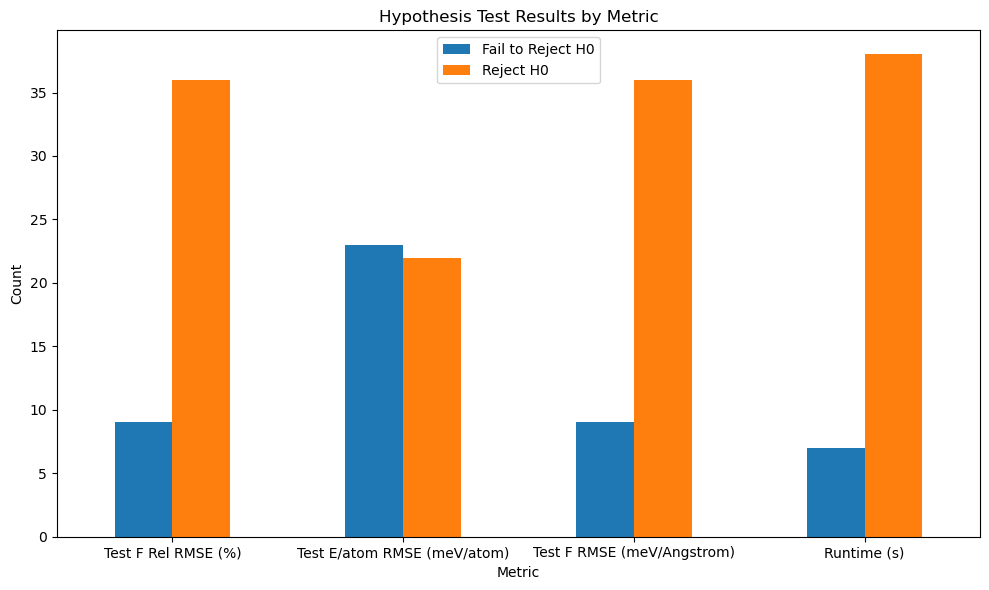

In [23]:
import matplotlib.pyplot as plt
real_labels = ['Test F Rel RMSE (%)', 'Test E/atom RMSE (meV/atom)', 'Test F RMSE (meV/Angstrom)', 'Runtime (s)' ]
h0_results_filtered = h0_results[~h0_results.index.str.startswith('valid')]
h0_results_filtered.index = real_labels
h0_results_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Hypothesis Test Results by Metric')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


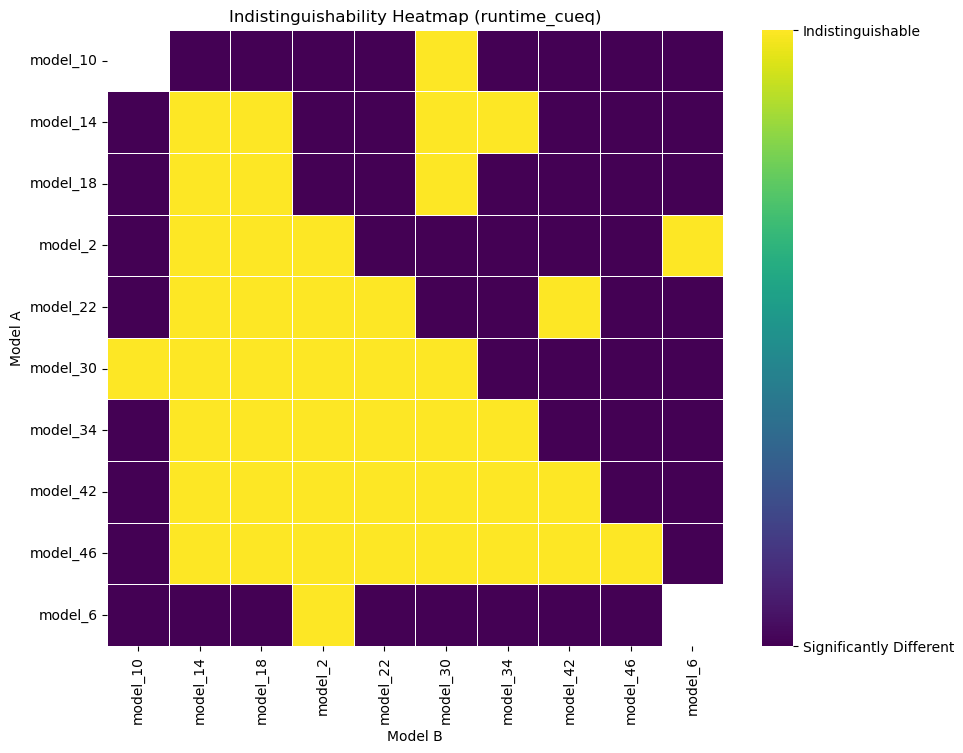

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


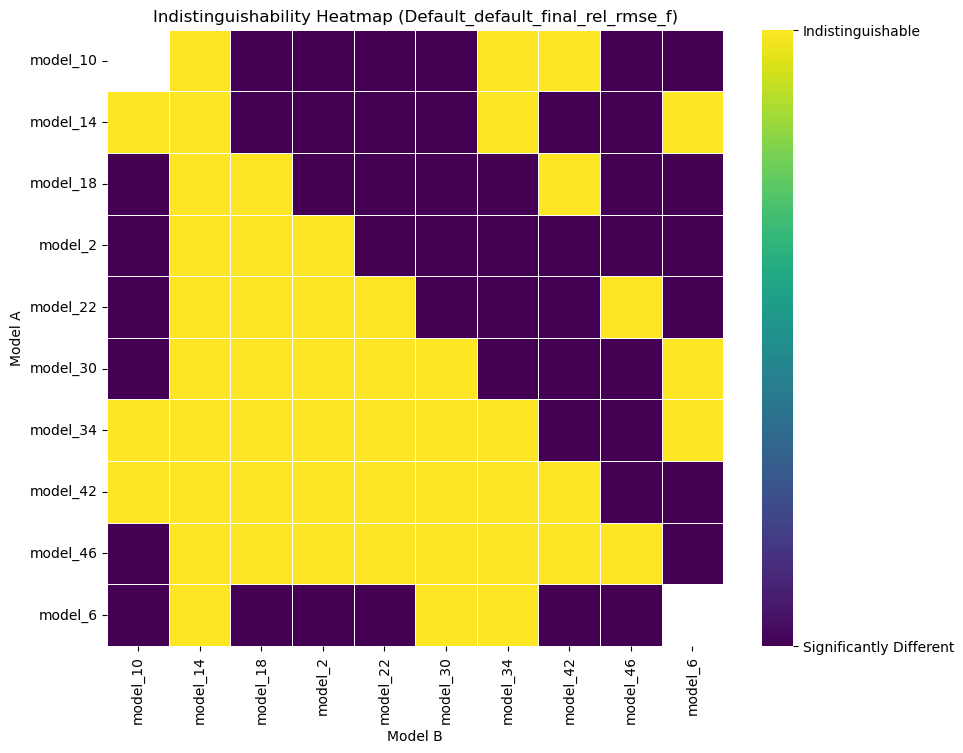

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


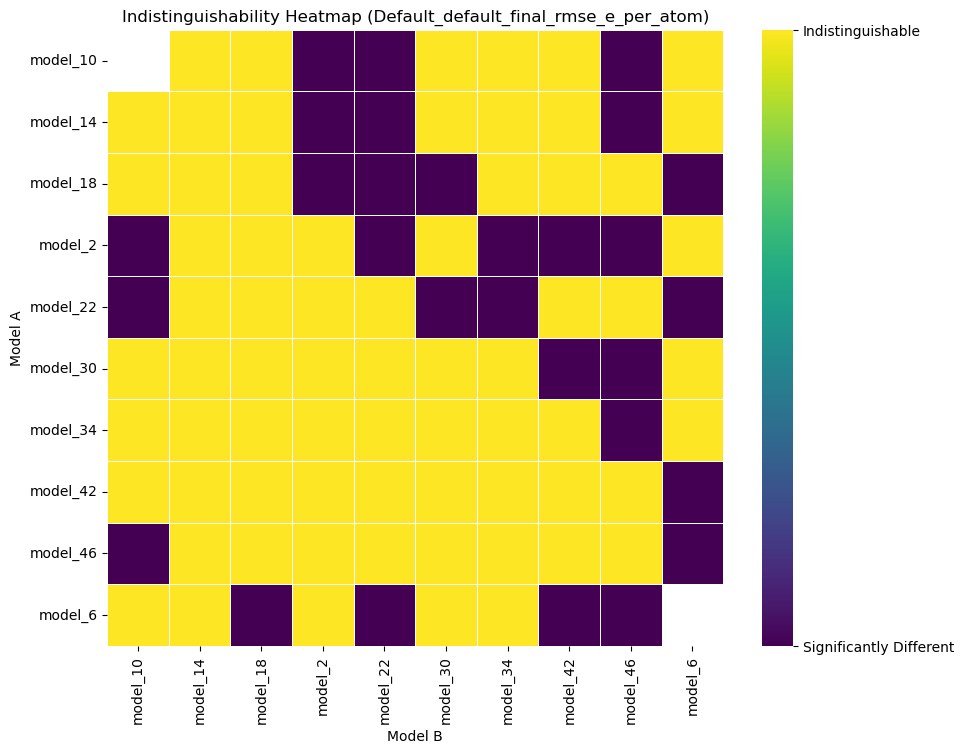

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


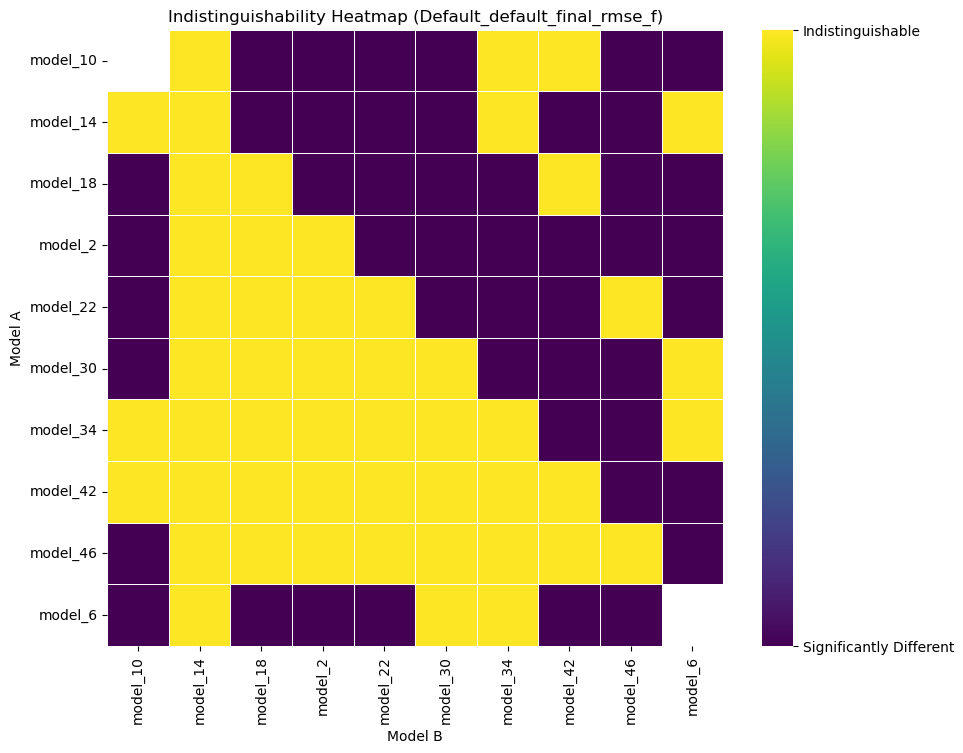

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


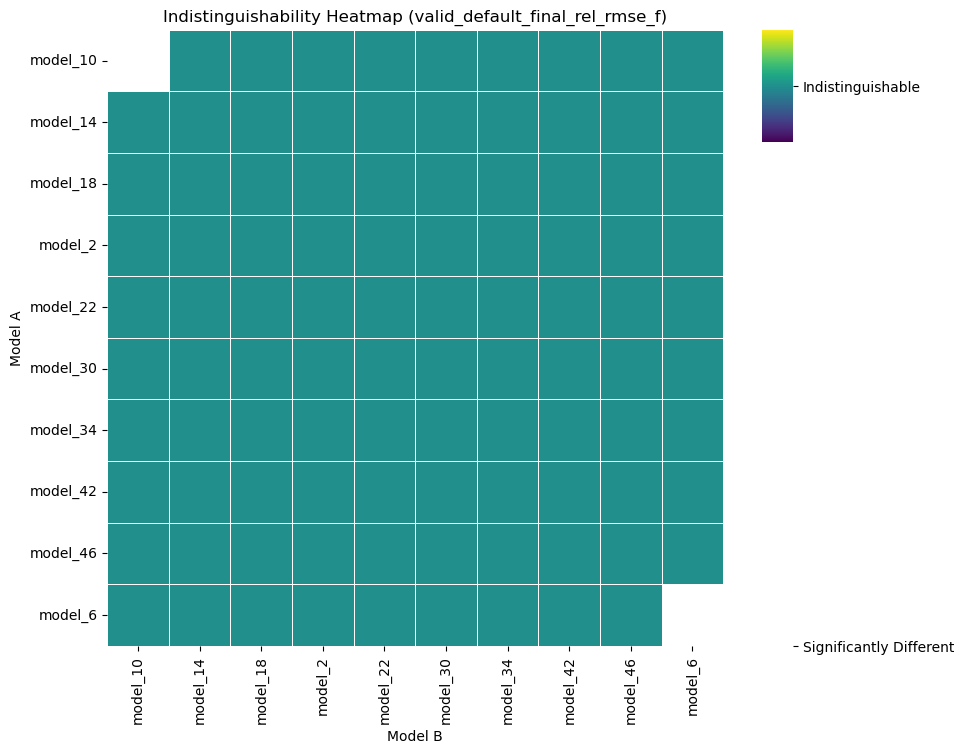

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


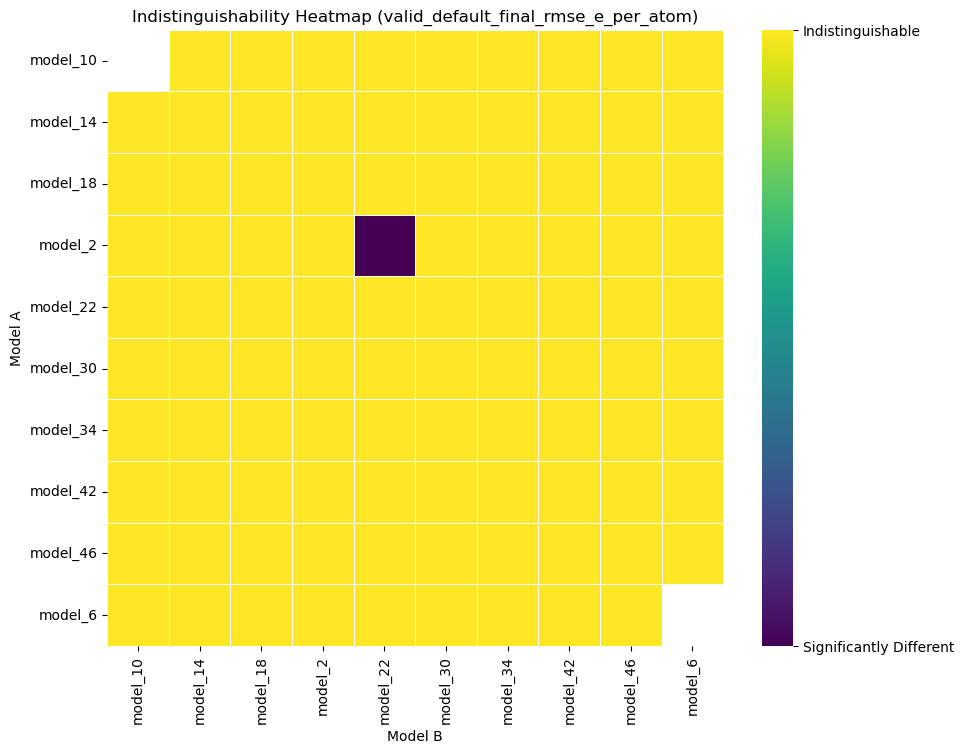

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_54199/3566455232.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int


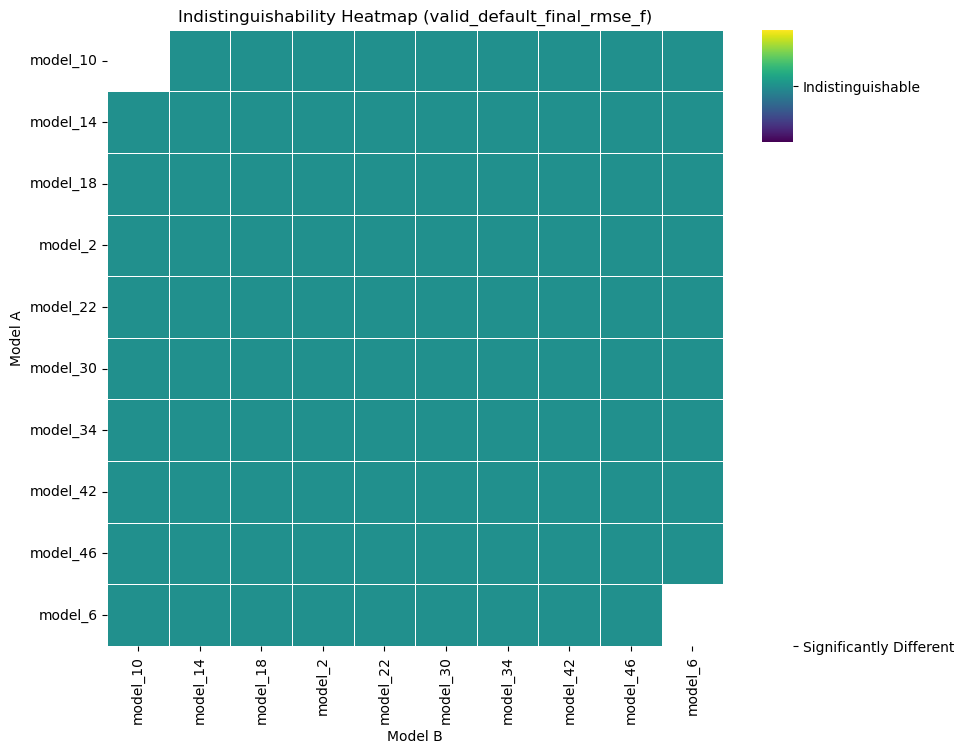

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "data/hpo_analysis/pairwise_test_results.csv"
df = pd.read_csv(file_path)

# Get unique metrics
metrics = df["metric"].unique()

# Generate heatmaps for each metric
for metric in metrics:
    # Filter data for the specific metric
    metric_data = df[df["metric"] == metric]
    
    # Create a pivot table for heatmap (1 = Fail to Reject H0, 0 = Reject H0)
    heatmap_data = metric_data.pivot(index="modelA", columns="modelB", values="reject_H0")
    heatmap_data = heatmap_data.fillna(0).astype(int)  # Fill NaN with 0 and convert to int
    heatmap_data = 1 - heatmap_data  # Convert: 1 = indistinguishable, 0 = significantly different

    # Fill diagonal (self-comparison) with 1
    for model in heatmap_data.index:
        if model in heatmap_data.columns:
            heatmap_data.at[model, model] = 1

    # Ensure symmetric heatmap
    heatmap_data = heatmap_data.combine_first(heatmap_data.T)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(heatmap_data, cmap="viridis", linewidths=0.5, cbar=True, square=True)  # Set cbar=True to show color bar
    plt.title(f"Indistinguishability Heatmap ({metric})")
    plt.xlabel("Model B")
    plt.ylabel("Model A")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    # Add a color bar label
    cbar = heatmap.collections[0].colorbar  # Get the color bar from the heatmap object
    cbar.set_ticks([0, 1])  # Set ticks for the color bar
    cbar.set_ticklabels(['Significantly Different', 'Indistinguishable'])  # Set labels for the ticks

    plt.show()

## Pareto Front Analysis

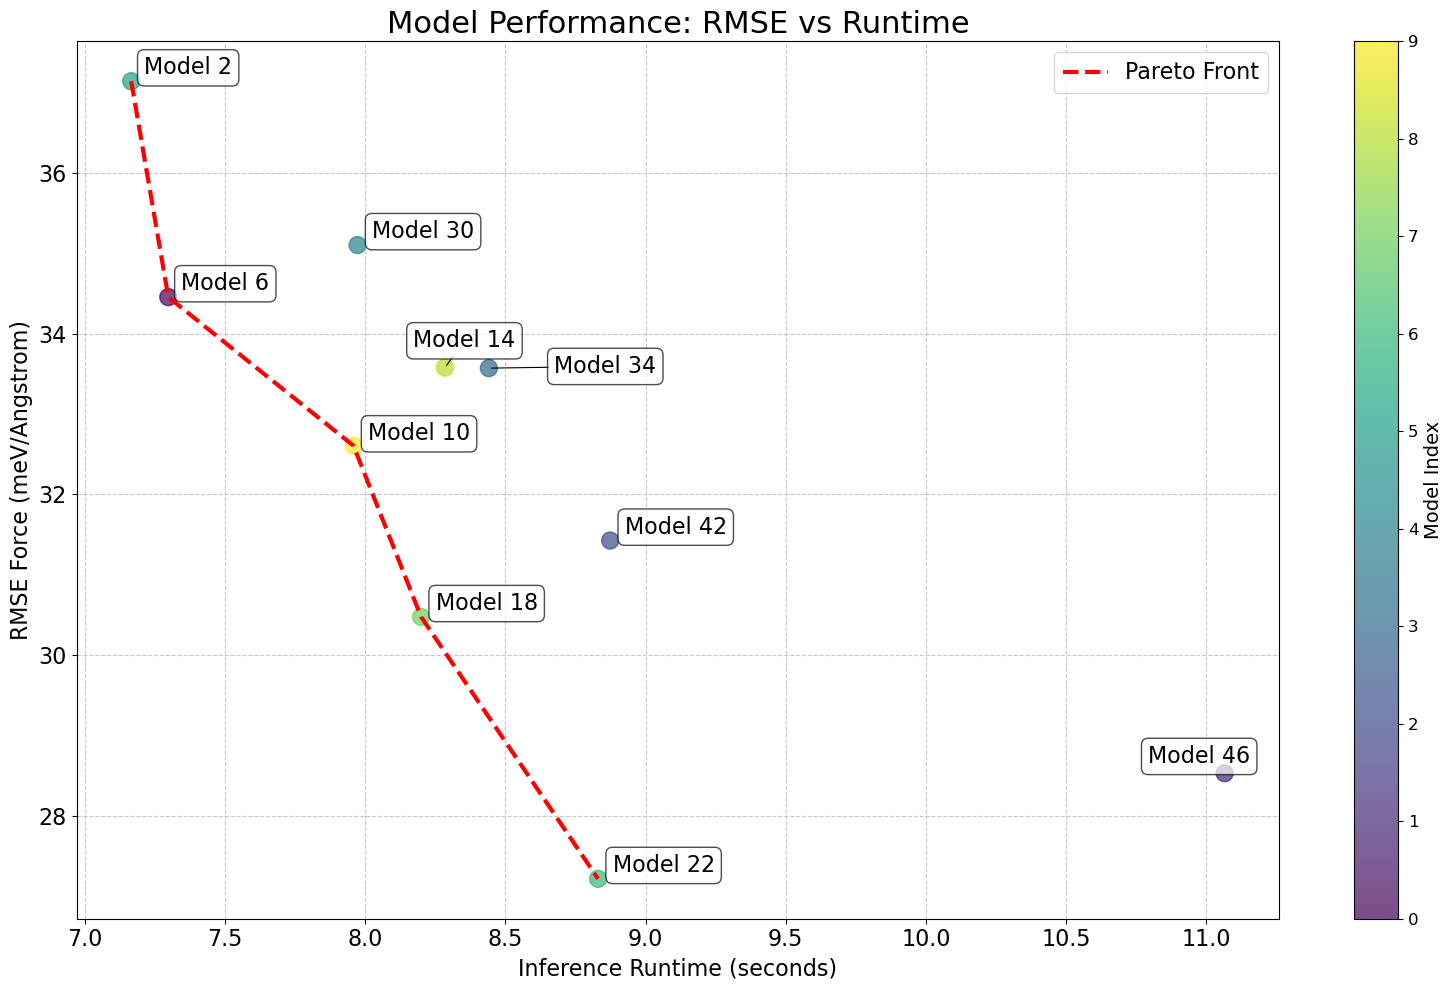


LaTeX Table for Model Parameters:

\begin{table}[htbp]
\centering
\caption{Model Performance and Hyperparameters}
\begin{tabular}{lcccccc}
\toprule
Model & RMSE & Runtime (s) & $r_{\text{max}}$ & $L_{\text{max}}$ & Channels & Learning Rate \\
\midrule
model_22 & 27.215 & 8.831 & 5.0 & 1 & 128 & 0.0010 \\
model_46 & 28.529 & 11.067 & 6.0 & 1 & 128 & 0.0010 \\
model_18 & 30.475 & 8.199 & 5.0 & 1 & 64 & 0.0010 \\
model_42 & 31.426 & 8.874 & 6.0 & 1 & 64 & 0.0010 \\
model_10 & 32.605 & 7.958 & 5.0 & 0 & 128 & 0.0010 \\
model_34 & 33.571 & 8.441 & 6.0 & 0 & 128 & 0.0010 \\
model_14 & 33.578 & 8.284 & 5.0 & 1 & 32 & 0.0010 \\
model_6 & 34.455 & 7.297 & 5.0 & 0 & 64 & 0.0010 \\
model_30 & 35.103 & 7.972 & 6.0 & 0 & 64 & 0.0010 \\
model_2 & 37.142 & 7.164 & 5.0 & 0 & 32 & 0.0010 \\
\bottomrule
\end{tabular}
\label{tab:model_params}
\end{table}

Pareto Optimal Models (best trade-offs between runtime and RMSE):
------------------------------------------------------------------------------------

In [8]:
import matplotlib.pyplot as plt
import json
import numpy as np
from adjustText import adjust_text
import pandas as pd

def extract_hyperparams(params_str):
    """Extract hyperparameters from the params string"""
    params = json.loads(params_str)
    name = params['name']
    
    # Extract parameters from the name string
    try:
        r_max = float(name.split('r_cut')[1].split('_')[0]) if 'r_cut' in name else None
        max_L = int(name.split('max_L')[1].split('_')[0]) if 'max_L' in name else None
        num_channels = int(name.split('num_channels')[1].split('_')[0]) if 'num_channels' in name else None
        learning_rate = float(name.split('learning_rate')[1].split('_')[0]) if 'learning_rate' in name else None
    except (IndexError, ValueError):
        r_max, max_L, num_channels, learning_rate = None, None, None, None
        
    return {
        'r_max': r_max,
        'max_L': max_L,
        'num_channels': num_channels,
        'learning_rate': learning_rate
    }

def generate_latex_table(models, rmse_values, runtime_values, hyperparams_list, pareto_labels=None):
    """Generate a LaTeX table string for the model parameters"""
    latex_str = "\\begin{table}[htbp]\n\\centering\n"
    latex_str += "\\caption{Model Performance and Hyperparameters}\n"
    latex_str += "\\begin{tabular}{lcccccc}\n"
    latex_str += "\\toprule\n"
    latex_str += "Model & RMSE & Runtime (s) & $r_{\\text{max}}$ & $L_{\\text{max}}$ & Channels & Learning Rate \\\\\n"
    latex_str += "\\midrule\n"
    
    # Sort by RMSE for better presentation
    sorted_data = sorted(zip(models, rmse_values, runtime_values, hyperparams_list), 
                         key=lambda x: x[1])  # Sort by RMSE
    
    for model, rmse, runtime, hp in sorted_data:
        # Highlight Pareto optimal models
        if pareto_labels and model in pareto_labels:
            row_start = "\\rowcolor{lightgray} "
        else:
            row_start = ""
            
        latex_str += f"{row_start}{model} & {rmse:.3f} & {runtime:.3f} & "
        latex_str += f"{hp['r_max']} & {hp['max_L']} & {hp['num_channels']} & "
        
        if hp['learning_rate'] is not None:
            latex_str += f"{hp['learning_rate']:.4f} \\\\\n"
        else:
            latex_str += "-- \\\\\n"
    
    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\label{tab:model_params}\n"
    latex_str += "\\end{table}"
    
    return latex_str

# Load the ensemble stats results
with open('data/hpo_analysis/ensemble_stats_results.json', 'r') as f:
    ensemble_stats = json.load(f)

# Create a dictionary to store hyperparameters for each model
model_hyperparams = {}
for i in range(len(df)):
    params_str = df.iloc[i]['params']
    model_name = json.loads(params_str)['name'].split('_r_cut')[0]
    
    if model_name not in model_hyperparams:
        model_hyperparams[model_name] = extract_hyperparams(params_str)

# Extract data for plotting
models = []
rmse_values = []
runtime_values = []
labels = []
hyperparams_list = []

for model_name, stats in ensemble_stats.items():
    models.append(model_name)
    rmse_values.append(stats['rmse_f_mean'])
    runtime_values.append(stats['runtime_mean'])
    labels.append(f"Model {model_name.split('_')[1]}")
    hyperparams_list.append(model_hyperparams.get(model_name, 
                                                 {'r_max': None, 'max_L': None, 
                                                  'num_channels': None, 'learning_rate': None}))

# Create the scatter plot
plt.figure(figsize=(16, 10))

# Plot points
scatter = plt.scatter(
    runtime_values, 
    rmse_values,
    s=150,  # Increased point size
    alpha=0.7,
    c=np.arange(len(models)),  # Color points by model index for better distinction
    cmap='viridis'
)

# Create texts for labels (we'll adjust them later)
texts = []
for i, label in enumerate(labels):
    texts.append(plt.text(
        runtime_values[i], rmse_values[i],
        label,
        fontsize=16,  # Increased font size
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7)
    ))

# Add a colorbar for reference
cbar = plt.colorbar(scatter, label='Model Index')
cbar.ax.tick_params(labelsize=12)  # Larger colorbar tick labels
cbar.set_label('Model Index', size=14)  # Larger colorbar label

# Add title and labels with larger font sizes
plt.title('Model Performance: RMSE vs Runtime', fontsize=22)
plt.xlabel('Inference Runtime (seconds)', fontsize=16)
plt.ylabel('RMSE Force (meV/Angstrom)', fontsize=16)

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=16)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the Pareto front
# Sort points by runtime
sorted_indices = np.argsort(runtime_values)
sorted_runtimes = [runtime_values[i] for i in sorted_indices]
sorted_rmses = [rmse_values[i] for i in sorted_indices]

# Find Pareto optimal points
pareto_indices = []
current_min_rmse = float('inf')

for i in range(len(sorted_indices)):
    if sorted_rmses[i] < current_min_rmse:
        pareto_indices.append(sorted_indices[i])
        current_min_rmse = sorted_rmses[i]

# Connect Pareto optimal points with a line
pareto_runtimes = [runtime_values[i] for i in pareto_indices]
pareto_rmses = [rmse_values[i] for i in pareto_indices]
pareto_labels = [labels[i] for i in pareto_indices]
pareto_hyperparams = [hyperparams_list[i] for i in pareto_indices]

# Sort Pareto points by runtime
pareto_sorted = sorted(zip(pareto_runtimes, pareto_rmses, pareto_labels, pareto_hyperparams))
pareto_runtimes = [x[0] for x in pareto_sorted]
pareto_rmses = [x[1] for x in pareto_sorted]
pareto_labels = [x[2] for x in pareto_sorted]
pareto_hyperparams = [x[3] for x in pareto_sorted]

plt.plot(pareto_runtimes, pareto_rmses, 'r--', linewidth=3, label='Pareto Front')  # Thicker line

# Add a legend with larger font
plt.legend(loc='upper right', fontsize=16)

# Adjust text positions to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.8))

plt.tight_layout()
plt.show()

# Generate and print LaTeX table
latex_table = generate_latex_table(models, rmse_values, runtime_values, hyperparams_list, pareto_labels)
print("\nLaTeX Table for Model Parameters:\n")
print(latex_table)

# Print a summary of Pareto optimal models
print("\nPareto Optimal Models (best trade-offs between runtime and RMSE):")
print("-" * 100)
print(f"{'Model':<10} {'RMSE':<10} {'Runtime':<10} {'r_max':<10} {'max_L':<10} {'num_channels':<15} {'learning_rate':<15}")
print("-" * 100)
for i, label in enumerate(pareto_labels):
    hp = pareto_hyperparams[i]
    print(f"{label:<10} {pareto_rmses[i]:<10.3f} {pareto_runtimes[i]:<10.3f} {hp['r_max']:<10} {hp['max_L']:<10} {hp['num_channels']:<15} {hp['learning_rate']:<15.4f}")

# Analyzing ensembles of top 10 models

In [17]:
data_path = './data/hpo_analysis/wandb_export_2025-02-26T08_49_24.871-05_00.csv'
df = pd.read_csv(data_path)

In [18]:
test_columns = [col for col in df.columns if 'Default_default' in col]
print(test_columns)

['Default_default_final_rel_rmse_f', 'Default_default_final_rmse_e_per_atom', 'Default_default_final_rmse_f']


In [19]:
# only get the rows where the test_columns are not nan
print(f'Number of rows before filtering: {len(df)}')
df = df.loc[df[test_columns[0]].notna()]
print(f'Number of rows after filtering: {len(df)}')


Number of rows before filtering: 62
Number of rows after filtering: 50


In [40]:
import json
row_0_dict = json.loads(df.iloc[0]['params'])
print(row_0_dict['seed'])
print(row_0_dict['name'])
print(df.iloc[0]['Default_default_final_rmse_f'])
print(df.iloc[0]['Default_default_final_rel_rmse_f'])
print(df.iloc[0]['Runtime'])
# let's group the names of the models by their names, and 


# first print 4
# second print model_6_r_cut5.0_max_L0_num_channels64_learning_rate0.001_batch_size4_final_seed_4
# third print 36.92500665783882
# fourth print 44.73343111006553
# fifth print 23652 (runtime in seconds)


4
model_6_r_cut5.0_max_L0_num_channels64_learning_rate0.001_batch_size4_final_seed_4
36.92500665783882
44.73343111006553
23652


In [47]:
import json
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import itertools
import statsmodels.stats.power as smp


def group_model_data(df):
    """Groups model data and calculates statistics, including p-values and power."""

    grouped_data = defaultdict(lambda: {"seeds": [], "rmse_f": [], "rel_rmse_f": [], "runtimes": []})

    for i in range(len(df)):
        row_dict = json.loads(df.iloc[i]['params'])
        full_name = row_dict['name']
        seed = row_dict['seed']
        base_name = full_name.split('_r_cut')[0]

        grouped_data[base_name]["seeds"].append(int(seed))
        grouped_data[base_name]["rmse_f"].append(float(df.iloc[i]['Default_default_final_rmse_f']))
        grouped_data[base_name]["rel_rmse_f"].append(float(df.iloc[i]['Default_default_final_rel_rmse_f']))
        grouped_data[base_name]["runtimes"].append(int(df.iloc[i]['Runtime']))

    # Calculate statistics and p-values
    results = {}
    model_names = list(grouped_data.keys())

    for base_name, data in grouped_data.items():
        results[base_name] = {
            "rmse_f_mean": np.mean(data["rmse_f"]),
            "rmse_f_std": np.std(data["rmse_f"]),
            "rel_rmse_f_mean": np.mean(data["rel_rmse_f"]),
            "rel_rmse_f_std": np.std(data["rel_rmse_f"]),
            "runtime_mean": np.mean(data["runtimes"]),
            "runtime_std": np.std(data["runtimes"]),
            "rmse_f_p_values": {},
            "rel_rmse_f_p_values": {},
            "runtimes_p_values": {},
            "rmse_f_power": {},  # Store calculated power
            "rel_rmse_f_power": {},
            "runtimes_power": {},
        }

    # Perform t-tests, calculate effect size, and power
    for model1, model2 in itertools.combinations(model_names, 2):
        for metric in ["rmse_f", "rel_rmse_f", "runtimes"]:
            data1 = grouped_data[model1][metric]
            data2 = grouped_data[model2][metric]

            # Welch's t-test
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)

            # Store p-value
            results[model1][f"{metric}_p_values"][model2] = p_value
            results[model2][f"{metric}_p_values"][model1] = p_value

            # Calculate effect size (Cohen's d for unequal variances)
            n1 = len(data1)
            n2 = len(data2)
            s1 = np.std(data1, ddof=1)  # Use ddof=1 for sample standard deviation
            s2 = np.std(data2, ddof=1)
            pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
            effect_size = (np.mean(data1) - np.mean(data2)) / pooled_std

            # Calculate power using statsmodels
            power = smp.ttest_power(effect_size, nobs=n1, alpha=0.05, alternative='two-sided') # Use nobs of the first group

            # Store power
            results[model1][f"{metric}_power"][model2] = power
            results[model2][f"{metric}_power"][model1] = power # Power is symmetric


    return grouped_data,results

grouped_results, stats_results = group_model_data(df)

In [50]:
json.dump(stats_results, open('./data/hpo_analysis/ensemble_stats_results.json', 'w'))

In [61]:
stats_results['model_10']['rmse_f_power']
stats_results['model_10']['rel_rmse_f_power']
stats_results['model_10']['runtimes_power']


{'model_6': 0.984403908421163,
 'model_46': 1.0,
 'model_42': 1.0,
 'model_34': 1.0,
 'model_14': 0.1888198327725531,
 'model_30': 1.0,
 'model_22': 1.0,
 'model_18': 1.0,
 'model_2': 1.0}

In [51]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Load the provided data
data = {
    "model_6": {
        "rmse_f_mean": 37.9218, "rmse_f_std": 0.8214,
        "rel_rmse_f_mean": 45.9410, "rel_rmse_f_std": 0.9950,
        "runtime_mean": 33395.4, "runtime_std": 20228.76
    },
    "model_46": {
        "rmse_f_mean": 35.3426, "rmse_f_std": 1.3251,
        "rel_rmse_f_mean": 42.8164, "rel_rmse_f_std": 1.6053,
        "runtime_mean": 26450.4, "runtime_std": 270.26
    },
    "model_42": {
        "rmse_f_mean": 37.2766, "rmse_f_std": 1.3238,
        "rel_rmse_f_mean": 45.1594, "rel_rmse_f_std": 1.6037,
        "runtime_mean": 25805.6, "runtime_std": 255.21
    },
    "model_34": {
        "rmse_f_mean": 36.5346, "rmse_f_std": 0.3160,
        "rel_rmse_f_mean": 44.2605, "rel_rmse_f_std": 0.3828,
        "runtime_mean": 23487.0, "runtime_std": 379.44
    },
    "model_14": {
        "rmse_f_mean": 36.8497, "rmse_f_std": 0.6395,
        "rel_rmse_f_mean": 44.6422, "rel_rmse_f_std": 0.7747,
        "runtime_mean": 60253.0, "runtime_std": 28310.24
    },
    "model_10": {
        "rmse_f_mean": 36.3726, "rmse_f_std": 1.0765,
        "rel_rmse_f_mean": 44.0643, "rel_rmse_f_std": 1.3042,
        "runtime_mean": 74099.6, "runtime_std": 914.01
    },
    "model_30": {
        "rmse_f_mean": 38.7410, "rmse_f_std": 1.0613,
        "rel_rmse_f_mean": 46.9335, "rel_rmse_f_std": 1.2857,
        "runtime_mean": 23337.8, "runtime_std": 155.94
    },
    "model_22": {
        "rmse_f_mean": 33.6181, "rmse_f_std": 0.7891,
        "rel_rmse_f_mean": 40.7272, "rel_rmse_f_std": 0.9559,
        "runtime_mean": 25773.2, "runtime_std": 290.70
    },
    "model_18": {
        "rmse_f_mean": 35.2980, "rmse_f_std": 0.8868,
        "rel_rmse_f_mean": 42.7624, "rel_rmse_f_std": 1.0744,
        "runtime_mean": 25688.6, "runtime_std": 284.32
    },
    "model_2": {
        "rmse_f_mean": 39.4547, "rmse_f_std": 0.8453,
        "rel_rmse_f_mean": 47.7981, "rel_rmse_f_std": 1.0240,
        "runtime_mean": 22847.2, "runtime_std": 140.11
    }
}

# Define function to compute Cohen's d for all pairwise comparisons
def compute_cohens_d(model1, model2):
    mean1, std1 = model1["rmse_f_mean"], model1["rmse_f_std"]
    mean2, std2 = model2["rmse_f_mean"], model2["rmse_f_std"]
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    d_rmse = (mean1 - mean2) / pooled_std

    mean1, std1 = model1["rel_rmse_f_mean"], model1["rel_rmse_f_std"]
    mean2, std2 = model2["rel_rmse_f_mean"], model2["rel_rmse_f_std"]
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    d_rel_rmse = (mean1 - mean2) / pooled_std

    mean1, std1 = model1["runtime_mean"], model1["runtime_std"]
    mean2, std2 = model2["runtime_mean"], model2["runtime_std"]
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    d_runtime = (mean1 - mean2) / pooled_std

    return d_rmse, d_rel_rmse, d_runtime

# Compute Cohen's d for each pair of models
models = list(data.keys())
effect_sizes = []

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        model1, model2 = models[i], models[j]
        d_rmse, d_rel_rmse, d_runtime = compute_cohens_d(data[model1], data[model2])
        effect_sizes.append((model1, model2, d_rmse, d_rel_rmse, d_runtime))

# Convert to DataFrame for analysis
effect_sizes_df = pd.DataFrame(effect_sizes, columns=["Model 1", "Model 2", "Cohen's d (RMSE)", "Cohen's d (Rel RMSE)", "Cohen's d (Runtime)"])

# Display results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Effect Sizes of Model Comparisons", dataframe=effect_sizes_df)


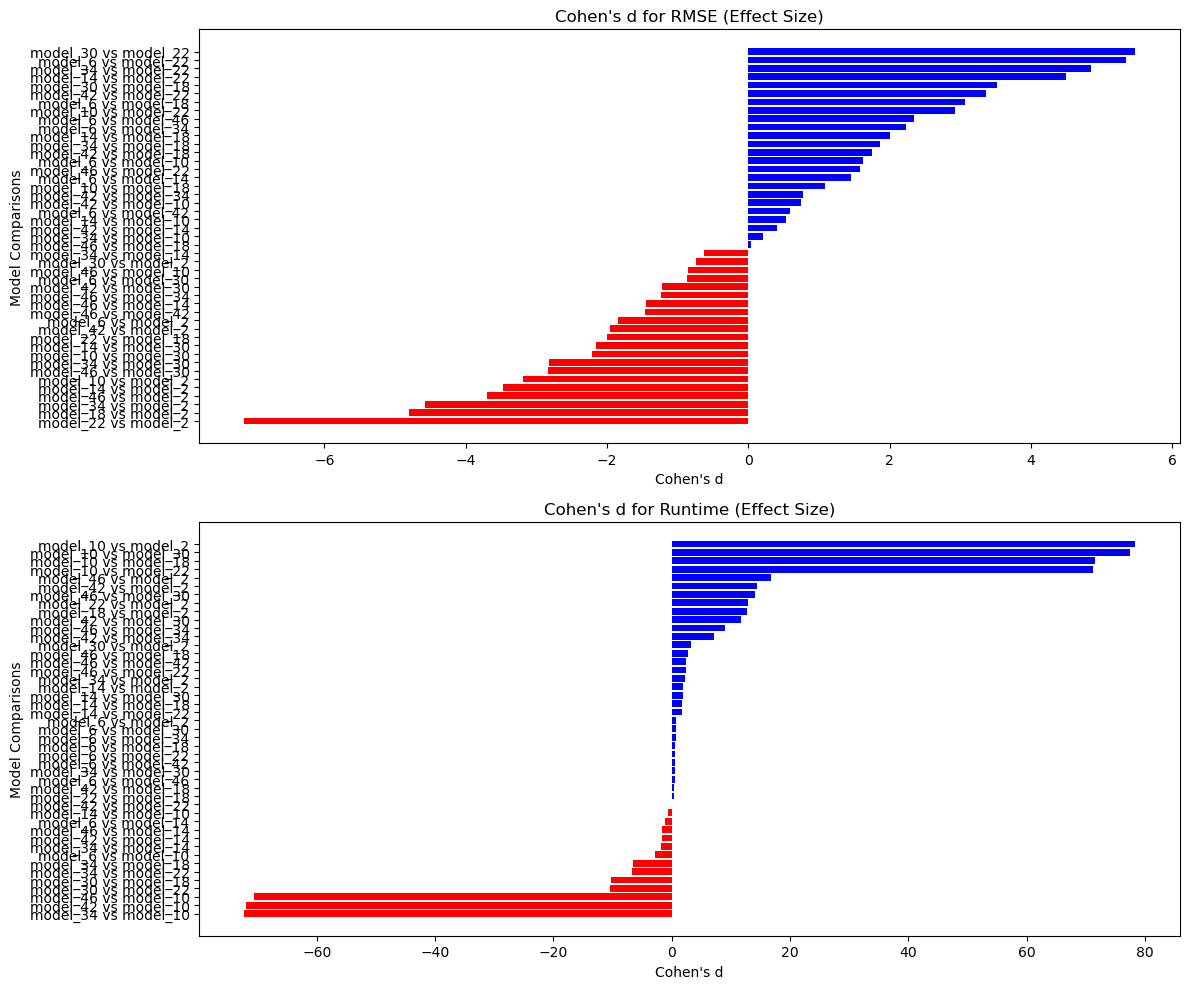

In [52]:
import matplotlib.pyplot as plt

# Define function to compute required sample size for 80% power
def required_sample_size(effect_size, alpha=0.05, power=0.8):
    """Calculates required sample size for given effect size, alpha, and power."""
    z_alpha = norm.ppf(1 - alpha / 2)  # Two-tailed test
    z_beta = norm.ppf(power)  # Power threshold
    return ((z_alpha + z_beta) ** 2 * 2) / (effect_size ** 2)

# Compute required sample sizes for all pairwise comparisons
effect_sizes_df["Required Sample Size (RMSE)"] = effect_sizes_df["Cohen's d (RMSE)"].apply(
    lambda d: np.ceil(required_sample_size(abs(d))) if abs(d) > 0 else np.nan
)
effect_sizes_df["Required Sample Size (Rel RMSE)"] = effect_sizes_df["Cohen's d (Rel RMSE)"].apply(
    lambda d: np.ceil(required_sample_size(abs(d))) if abs(d) > 0 else np.nan
)
effect_sizes_df["Required Sample Size (Runtime)"] = effect_sizes_df["Cohen's d (Runtime)"].apply(
    lambda d: np.ceil(required_sample_size(abs(d))) if abs(d) > 0 else np.nan
)

# Display updated results
#tools.display_dataframe_to_user(name="Required Sample Sizes for 80% Power", dataframe=effect_sizes_df)

# Visualization of Cohen's d for RMSE and Runtime
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Sort values for better visualization
effect_sizes_df_sorted = effect_sizes_df.sort_values("Cohen's d (RMSE)", ascending=True)

# RMSE Cohen's d
axes[0].barh(
    [f"{m1} vs {m2}" for m1, m2 in zip(effect_sizes_df_sorted["Model 1"], effect_sizes_df_sorted["Model 2"])],
    effect_sizes_df_sorted["Cohen's d (RMSE)"],
    color=["red" if d < 0 else "blue" for d in effect_sizes_df_sorted["Cohen's d (RMSE)"]],
)
axes[0].set_title("Cohen's d for RMSE (Effect Size)")
axes[0].set_xlabel("Cohen's d")
axes[0].set_ylabel("Model Comparisons")

# Runtime Cohen's d
effect_sizes_df_sorted = effect_sizes_df.sort_values("Cohen's d (Runtime)", ascending=True)
axes[1].barh(
    [f"{m1} vs {m2}" for m1, m2 in zip(effect_sizes_df_sorted["Model 1"], effect_sizes_df_sorted["Model 2"])],
    effect_sizes_df_sorted["Cohen's d (Runtime)"],
    color=["red" if d < 0 else "blue" for d in effect_sizes_df_sorted["Cohen's d (Runtime)"]],
)
axes[1].set_title("Cohen's d for Runtime (Effect Size)")
axes[1].set_xlabel("Cohen's d")
axes[1].set_ylabel("Model Comparisons")

plt.tight_layout()
plt.show()


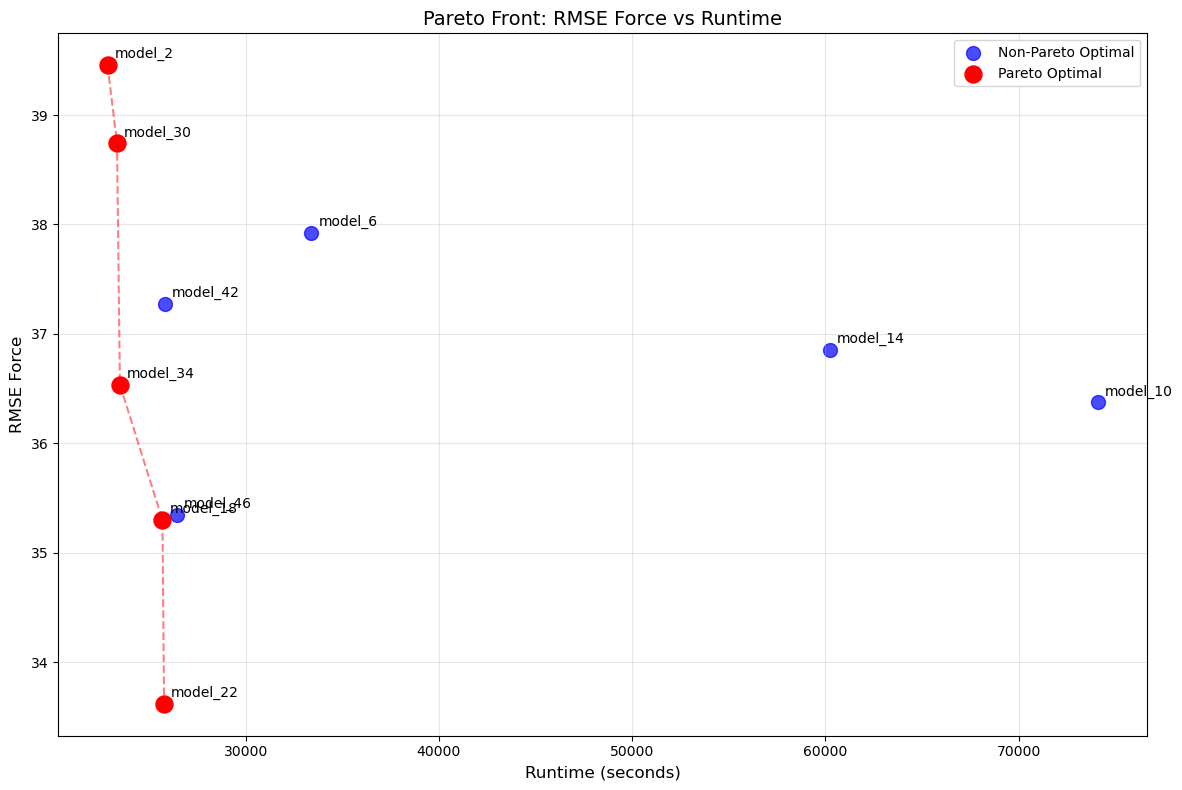

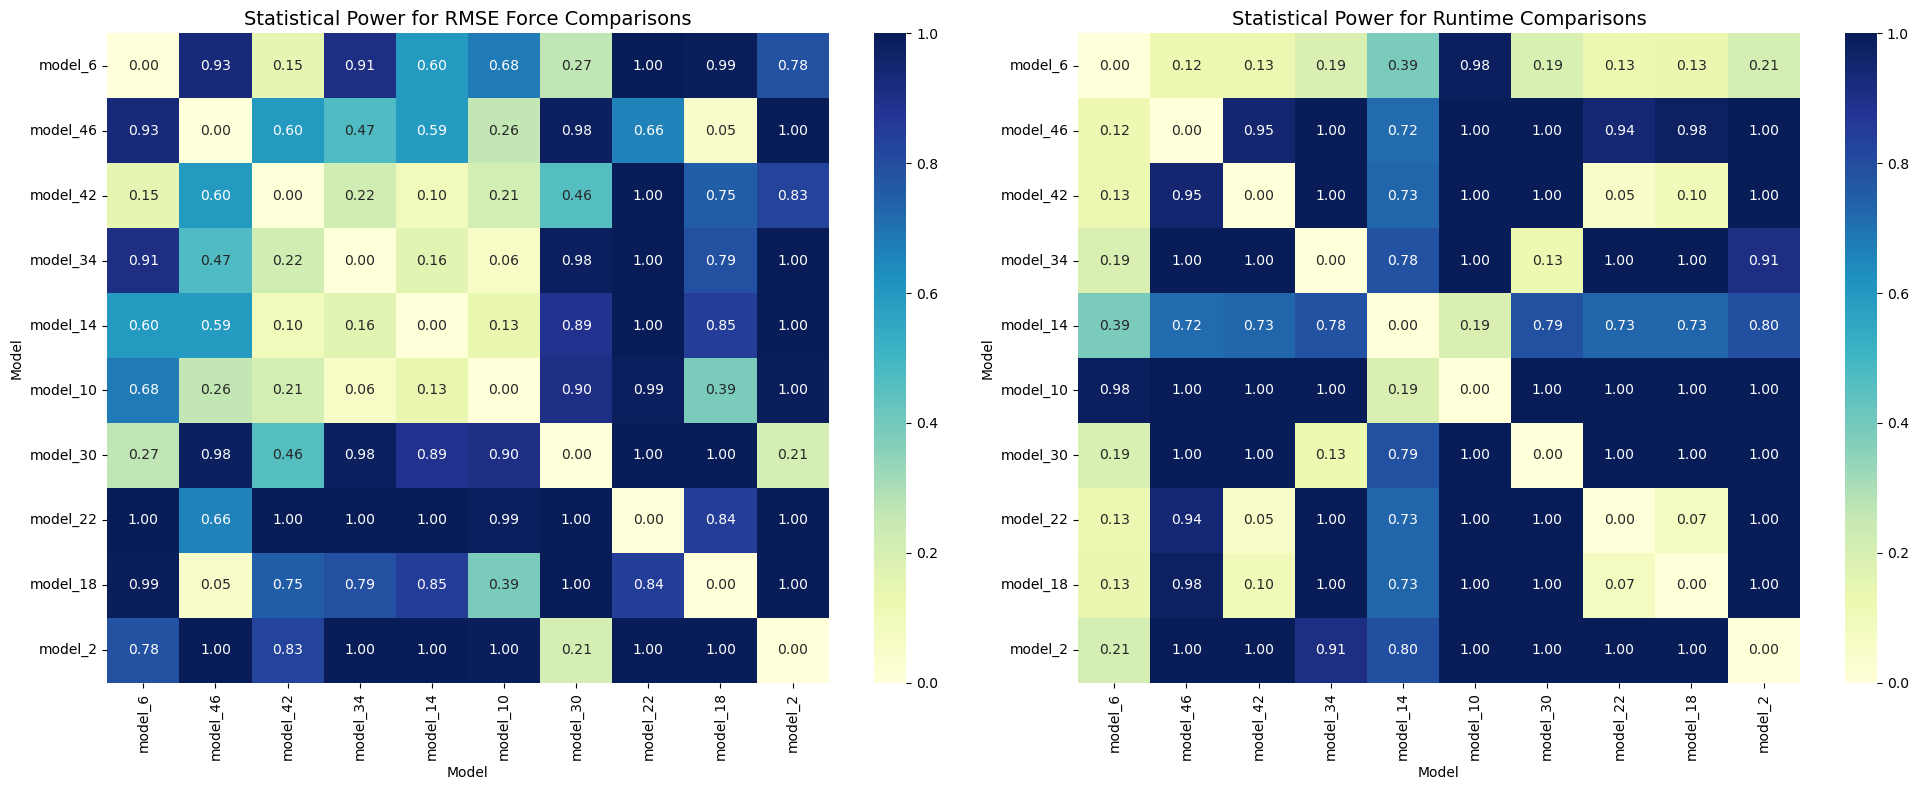

Pareto Optimal Models (sorted by RMSE):
      model  rmse_f_mean  rmse_f_std  runtime_mean  runtime_std
7  model_22    33.618110    0.789071       25773.2   290.699432
8  model_18    35.298011    0.886822       25688.6   284.324181
3  model_34    36.534648    0.315987       23487.0   379.437478
6  model_30    38.741009    1.061283       23337.8   155.940245
9   model_2    39.454740    0.845277       22847.2   140.107673

Best Model (lowest RMSE among Pareto optimal): model_22
The best model has significantly better RMSE than 8 other models (p < 0.05)
Of these, 8 comparisons have high statistical power (> 0.8)

Recommendation:
Model model_22 is recommended as it achieves the best accuracy among Pareto optimal models
and has statistically significant better performance than 8 other models with high confidence.


In [62]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats

# Load the ensemble stats results
with open('data/hpo_analysis/ensemble_stats_results.json', 'r') as f:
    ensemble_stats = json.load(f)

# Convert to DataFrame for easier manipulation
models_data = []
for model_name, stats in ensemble_stats.items():
    models_data.append({
        'model': model_name,
        'rmse_f_mean': stats['rmse_f_mean'],
        'rmse_f_std': stats['rmse_f_std'],
        'rel_rmse_f_mean': stats['rel_rmse_f_mean'],
        'rel_rmse_f_std': stats['rel_rmse_f_std'],
        'runtime_mean': stats['runtime_mean'],
        'runtime_std': stats['runtime_std']
    })

df_models = pd.DataFrame(models_data)

# Function to identify Pareto optimal models
def find_pareto_optimal(df, metrics, directions):
    """
    Find Pareto optimal models based on specified metrics and directions.
    
    Args:
        df: DataFrame with model data
        metrics: List of metrics to consider
        directions: List of directions ('min' or 'max') for each metric
        
    Returns:
        Boolean mask of Pareto optimal models
    """
    is_pareto = np.ones(len(df), dtype=bool)
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                dominates = True
                for metric, direction in zip(metrics, directions):
                    if direction == 'min':
                        if df.iloc[i][metric] > df.iloc[j][metric]:
                            dominates = False
                            break
                    else:  # 'max'
                        if df.iloc[i][metric] < df.iloc[j][metric]:
                            dominates = False
                            break
                
                if dominates:
                    is_pareto[j] = False
                    
    return is_pareto

# Find Pareto optimal models (minimize RMSE and runtime)
pareto_mask = find_pareto_optimal(
    df_models, 
    ['rmse_f_mean', 'runtime_mean'], 
    ['min', 'min']
)

df_models['is_pareto'] = pareto_mask

# Create a visualization of the Pareto front
plt.figure(figsize=(12, 8))

# Plot all models
plt.scatter(
    df_models[~df_models['is_pareto']]['runtime_mean'], 
    df_models[~df_models['is_pareto']]['rmse_f_mean'],
    alpha=0.7, s=100, color='blue', label='Non-Pareto Optimal'
)

# Highlight Pareto optimal models
plt.scatter(
    df_models[df_models['is_pareto']]['runtime_mean'], 
    df_models[df_models['is_pareto']]['rmse_f_mean'],
    alpha=1.0, s=150, color='red', label='Pareto Optimal'
)

# Add model names as labels
for i, row in df_models.iterrows():
    plt.annotate(
        row['model'], 
        (row['runtime_mean'], row['rmse_f_mean']),
        xytext=(5, 5), textcoords='offset points',
        fontsize=10
    )

# Connect Pareto optimal points with a line
pareto_df = df_models[df_models['is_pareto']].sort_values('runtime_mean')
plt.plot(
    pareto_df['runtime_mean'], 
    pareto_df['rmse_f_mean'], 
    'r--', alpha=0.5
)

plt.xlabel('Runtime (seconds)', fontsize=12)
plt.ylabel('RMSE Force', fontsize=12)
plt.title('Pareto Front: RMSE Force vs Runtime', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Create a heatmap of statistical power for RMSE_F
model_names = list(ensemble_stats.keys())
power_matrix_rmse = np.zeros((len(model_names), len(model_names)))
power_matrix_runtime = np.zeros((len(model_names), len(model_names)))

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i != j and model2 in ensemble_stats[model1]['rmse_f_power']:
            power_matrix_rmse[i, j] = ensemble_stats[model1]['rmse_f_power'][model2]
        if i != j and model2 in ensemble_stats[model1]['runtimes_power']:
            power_matrix_runtime[i, j] = ensemble_stats[model1]['runtimes_power'][model2]

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# RMSE Power heatmap
sns.heatmap(
    power_matrix_rmse, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    xticklabels=model_names, 
    yticklabels=model_names,
    ax=ax1
)
ax1.set_title('Statistical Power for RMSE Force Comparisons', fontsize=14)
ax1.set_xlabel('Model')
ax1.set_ylabel('Model')

# Runtime Power heatmap
sns.heatmap(
    power_matrix_runtime, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    xticklabels=model_names, 
    yticklabels=model_names,
    ax=ax2
)
ax2.set_title('Statistical Power for Runtime Comparisons', fontsize=14)
ax2.set_xlabel('Model')
ax2.set_ylabel('Model')

plt.tight_layout()
plt.show()

# Create a summary table of Pareto optimal models
pareto_models = df_models[df_models['is_pareto']].sort_values('rmse_f_mean')
print("Pareto Optimal Models (sorted by RMSE):")
print(pareto_models[['model', 'rmse_f_mean', 'rmse_f_std', 'runtime_mean', 'runtime_std']])

# Analyze the best model (lowest RMSE among Pareto optimal)
best_model = pareto_models.iloc[0]['model']
print(f"\nBest Model (lowest RMSE among Pareto optimal): {best_model}")

# Calculate how many models this best model has significantly better RMSE than (p < 0.05 and power > 0.8)
significant_better_count = 0
high_power_count = 0

for model in model_names:
    if model != best_model and model in ensemble_stats[best_model]['rmse_f_p_values']:
        p_value = ensemble_stats[best_model]['rmse_f_p_values'][model]
        power = ensemble_stats[best_model]['rmse_f_power'][model]
        
        if p_value < 0.05:
            significant_better_count += 1
            if power > 0.8:
                high_power_count += 1

print(f"The best model has significantly better RMSE than {significant_better_count} other models (p < 0.05)")
print(f"Of these, {high_power_count} comparisons have high statistical power (> 0.8)")

# Recommend the best model based on the analysis
print("\nRecommendation:")
if high_power_count > 0:
    print(f"Model {best_model} is recommended as it achieves the best accuracy among Pareto optimal models")
    print(f"and has statistically significant better performance than {high_power_count} other models with high confidence.")
else:
    print(f"Model {best_model} achieves the best accuracy among Pareto optimal models,")
    print("but more data may be needed to establish statistical significance with high confidence.")

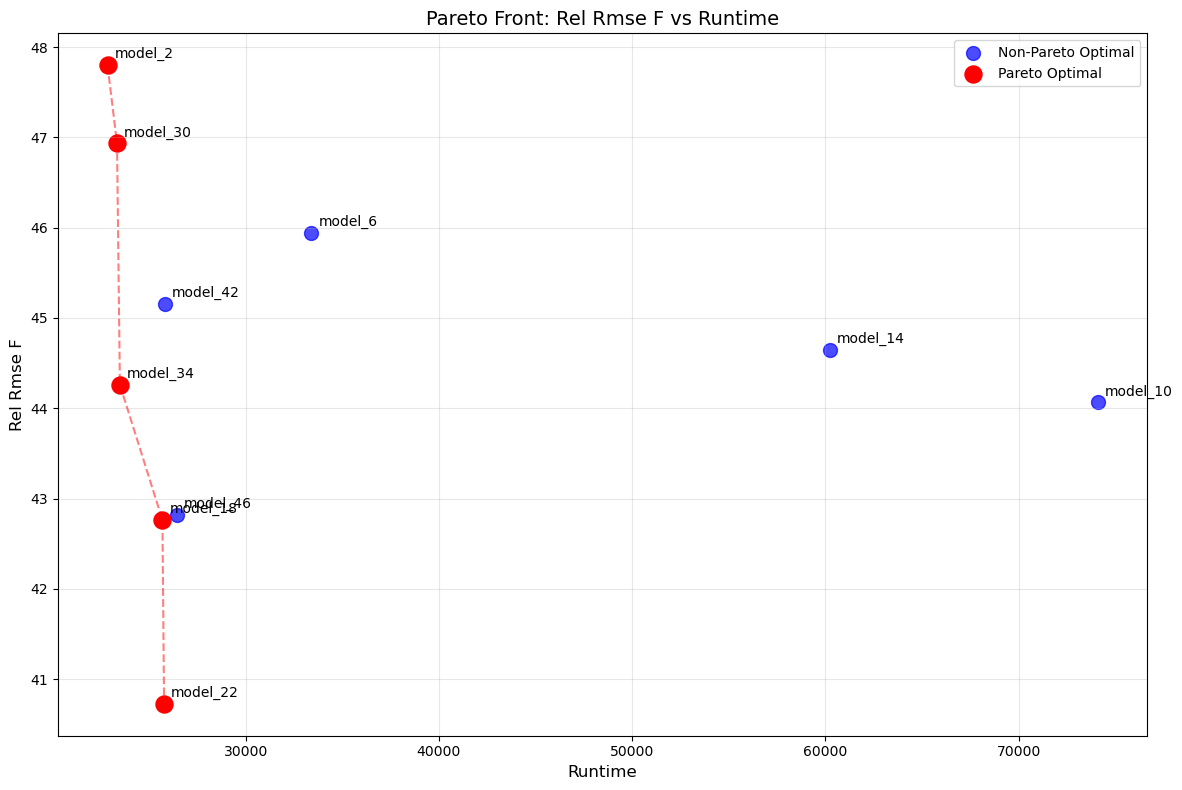

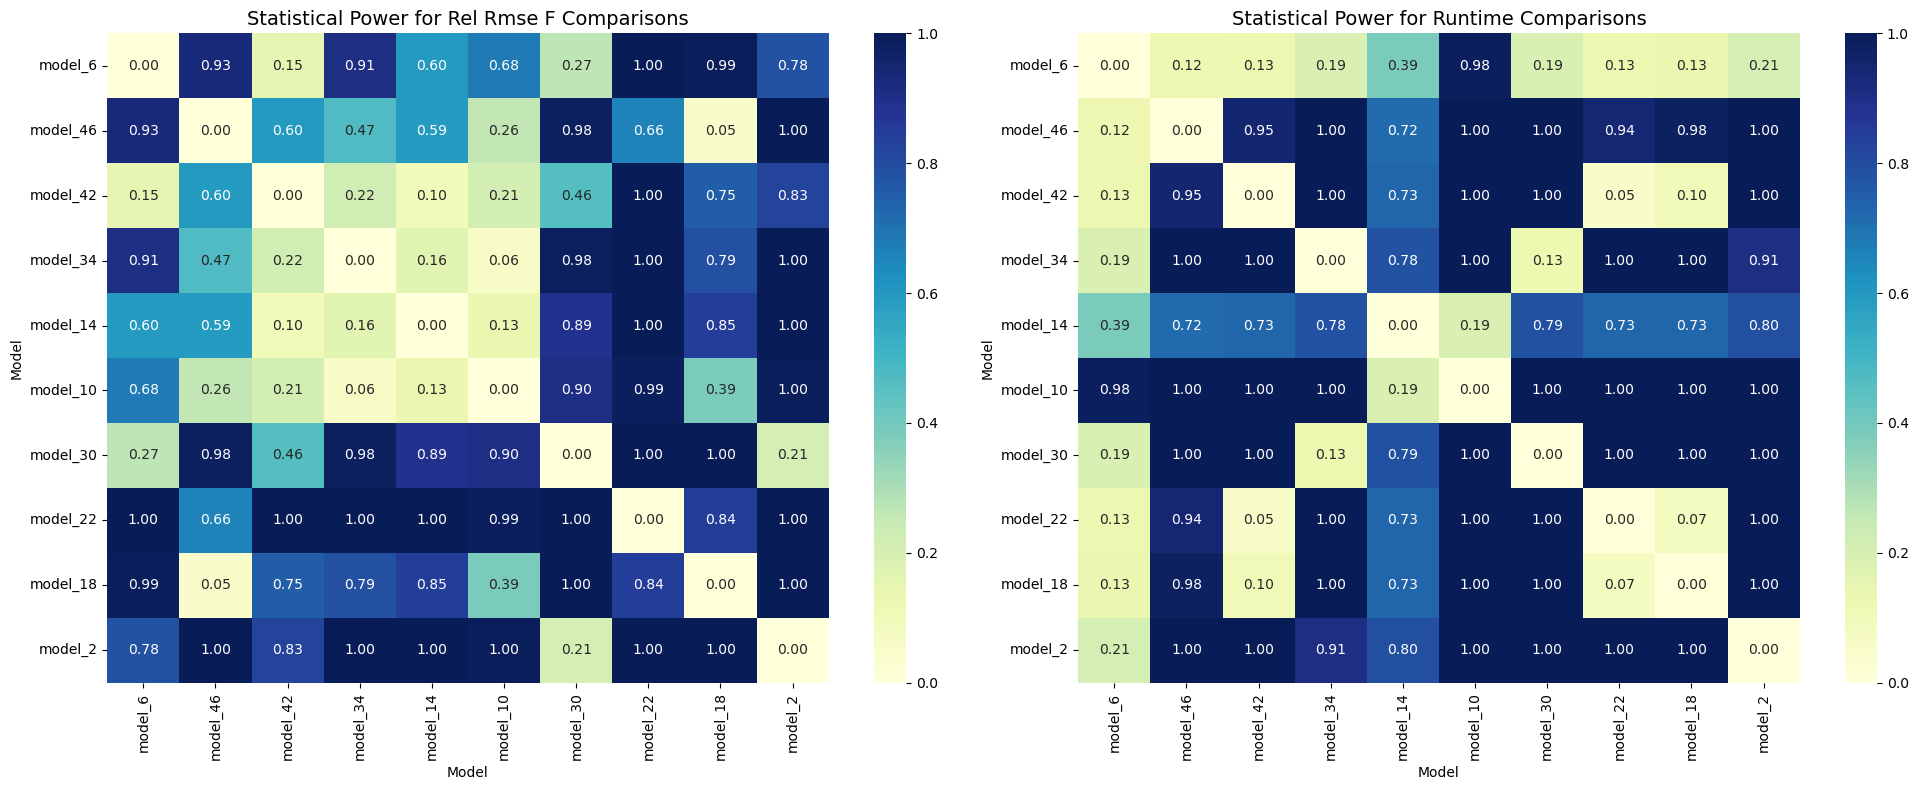

Pareto Optimal Models (sorted by Rel Rmse F):
      model  rel_rmse_f_mean  runtime_mean
7  model_22        40.727233       25773.2
8  model_18        42.762381       25688.6
3  model_34        44.260525       23487.0
6  model_30        46.933459       23337.8
9   model_2        47.798118       22847.2

Best Model (lowest Rel Rmse F among Pareto optimal): model_22
The best model has significantly better Rel Rmse F than 8 other models (p < 0.05)
Of these, 8 comparisons have high statistical power (> 0.8)

Recommendation:
Model model_22 is recommended as it achieves the best Rel Rmse F among Pareto optimal models
and has statistically significant better performance than 8 other models with high confidence.


In [65]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def find_pareto_optimal(df, metrics, directions):
    """
    Find Pareto optimal models based on specified metrics and directions.
    
    Args:
        df: DataFrame with model data
        metrics: List of metrics to consider
        directions: List of directions ('min' or 'max') for each metric
        
    Returns:
        Boolean mask of Pareto optimal models
    """
    is_pareto = np.ones(len(df), dtype=bool)
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                dominates = True
                for metric, direction in zip(metrics, directions):
                    if direction == 'min':
                        if df.iloc[i][metric] > df.iloc[j][metric]:
                            dominates = False
                            break
                    else:  # 'max'
                        if df.iloc[i][metric] < df.iloc[j][metric]:
                            dominates = False
                            break
                
                if dominates:
                    is_pareto[j] = False
                    
    return is_pareto

def analyze_pareto_front(df_models, metric_1, metric_2, direction_1='min', direction_2='min', 
                         ensemble_stats=None, power_threshold=0.8, p_value_threshold=0.05):
    """
    Analyze the Pareto front for two metrics and visualize results.
    
    Args:
        df_models: DataFrame with model data
        metric_1: First metric to consider (y-axis)
        metric_2: Second metric to consider (x-axis)
        direction_1: Direction for first metric ('min' or 'max')
        direction_2: Direction for second metric ('min' or 'max')
        ensemble_stats: Dictionary with statistical data
        power_threshold: Threshold for high statistical power
        p_value_threshold: Threshold for statistical significance
    """
    # Extract base metric names (without _mean suffix)
    base_metric_1 = metric_1.replace('_mean', '')
    base_metric_2 = metric_2.replace('_mean', '')
    
    # Find Pareto optimal models
    pareto_mask = find_pareto_optimal(
        df_models, 
        [metric_1, metric_2], 
        [direction_1, direction_2]
    )

    df_models['is_pareto'] = pareto_mask

    # Create a visualization of the Pareto front
    plt.figure(figsize=(12, 8))

    # Plot all models
    plt.scatter(
        df_models[~df_models['is_pareto']][metric_2], 
        df_models[~df_models['is_pareto']][metric_1],
        alpha=0.7, s=100, color='blue', label='Non-Pareto Optimal'
    )

    # Highlight Pareto optimal models
    plt.scatter(
        df_models[df_models['is_pareto']][metric_2], 
        df_models[df_models['is_pareto']][metric_1],
        alpha=1.0, s=150, color='red', label='Pareto Optimal'
    )

    # Add model names as labels
    for i, row in df_models.iterrows():
        plt.annotate(
            row['model'], 
            (row[metric_2], row[metric_1]),
            xytext=(5, 5), textcoords='offset points',
            fontsize=10
        )

    # Connect Pareto optimal points with a line
    pareto_df = df_models[df_models['is_pareto']].sort_values(metric_2)
    plt.plot(
        pareto_df[metric_2], 
        pareto_df[metric_1], 
        'r--', alpha=0.5
    )

    # Format axis labels to be more readable
    metric_1_label = metric_1.replace('_mean', '').replace('_', ' ').title()
    metric_2_label = metric_2.replace('_mean', '').replace('_', ' ').title()
    
    plt.xlabel(metric_2_label, fontsize=12)
    plt.ylabel(metric_1_label, fontsize=12)
    plt.title(f'Pareto Front: {metric_1_label} vs {metric_2_label}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # If ensemble_stats is provided, create statistical power heatmaps
    if ensemble_stats:
        model_names = list(ensemble_stats.keys())
        power_matrix_1 = np.zeros((len(model_names), len(model_names)))
        power_matrix_2 = np.zeros((len(model_names), len(model_names)))

        # Check which power key to use
        power_key_1 = f"{base_metric_1}_power"
        power_key_2 = f"{base_metric_2}_power"
        
        # Handle the special case for 'runtimes' vs 'runtime'
        if base_metric_1 == 'runtime' and 'runtimes_power' in ensemble_stats[model_names[0]]:
            power_key_1 = 'runtimes_power'
        if base_metric_2 == 'runtime' and 'runtimes_power' in ensemble_stats[model_names[0]]:
            power_key_2 = 'runtimes_power'

        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                if i != j and model2 in ensemble_stats[model1].get(power_key_1, {}):
                    power_matrix_1[i, j] = ensemble_stats[model1][power_key_1][model2]
                if i != j and model2 in ensemble_stats[model1].get(power_key_2, {}):
                    power_matrix_2[i, j] = ensemble_stats[model1][power_key_2][model2]

        # Create heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # First metric power heatmap
        sns.heatmap(
            power_matrix_1, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu", 
            xticklabels=model_names, 
            yticklabels=model_names,
            ax=ax1
        )
        ax1.set_title(f'Statistical Power for {metric_1_label} Comparisons', fontsize=14)
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Model')

        # Second metric power heatmap
        sns.heatmap(
            power_matrix_2, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu", 
            xticklabels=model_names, 
            yticklabels=model_names,
            ax=ax2
        )
        ax2.set_title(f'Statistical Power for {metric_2_label} Comparisons', fontsize=14)
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Model')

        plt.tight_layout()
        plt.show()

        # Create a summary table of Pareto optimal models
        pareto_models = df_models[df_models['is_pareto']].sort_values(metric_1)
        print(f"Pareto Optimal Models (sorted by {metric_1_label}):")
        print(pareto_models[['model', metric_1, metric_2]])

        # Analyze the best model (based on first metric among Pareto optimal)
        if direction_1 == 'min':
            best_model = pareto_models.iloc[0]['model']
            print(f"\nBest Model (lowest {metric_1_label} among Pareto optimal): {best_model}")
        else:
            best_model = pareto_models.iloc[-1]['model']
            print(f"\nBest Model (highest {metric_1_label} among Pareto optimal): {best_model}")

        # Calculate how many models this best model has significantly better metric than
        significant_better_count = 0
        high_power_count = 0
        
        # Handle the special case for 'runtimes' vs 'runtime'
        p_value_key = f"{base_metric_1}_p_values"
        if base_metric_1 == 'runtime' and 'runtimes_p_values' in ensemble_stats[best_model]:
            p_value_key = 'runtimes_p_values'

        for model in model_names:
            if model != best_model and model in ensemble_stats[best_model].get(p_value_key, {}):
                p_value = ensemble_stats[best_model][p_value_key][model]
                power = ensemble_stats[best_model][power_key_1][model]
                
                # Check if the difference is significant in the right direction
                if direction_1 == 'min':
                    better = df_models.loc[df_models['model'] == best_model, metric_1].values[0] < df_models.loc[df_models['model'] == model, metric_1].values[0]
                else:
                    better = df_models.loc[df_models['model'] == best_model, metric_1].values[0] > df_models.loc[df_models['model'] == model, metric_1].values[0]
                
                if p_value < p_value_threshold and better:
                    significant_better_count += 1
                    if power > power_threshold:
                        high_power_count += 1

        comparison_direction = "better" if direction_1 == 'min' else "higher"
        print(f"The best model has significantly {comparison_direction} {metric_1_label} than {significant_better_count} other models (p < {p_value_threshold})")
        print(f"Of these, {high_power_count} comparisons have high statistical power (> {power_threshold})")

        # Recommend the best model based on the analysis
        print("\nRecommendation:")
        if high_power_count > 0:
            print(f"Model {best_model} is recommended as it achieves the best {metric_1_label} among Pareto optimal models")
            print(f"and has statistically significant {comparison_direction} performance than {high_power_count} other models with high confidence.")
        else:
            print(f"Model {best_model} achieves the best {metric_1_label} among Pareto optimal models,")
            print("but more data may be needed to establish statistical significance with high confidence.")

# Load the ensemble stats results
with open('data/hpo_analysis/ensemble_stats_results.json', 'r') as f:
    ensemble_stats = json.load(f)

# Convert to DataFrame for easier manipulation
models_data = []
for model_name, stats in ensemble_stats.items():
    models_data.append({
        'model': model_name,
        'rmse_f_mean': stats['rmse_f_mean'],
        'rmse_f_std': stats['rmse_f_std'],
        'rel_rmse_f_mean': stats['rel_rmse_f_mean'],
        'rel_rmse_f_std': stats['rel_rmse_f_std'],
        'runtime_mean': stats['runtime_mean'],
        'runtime_std': stats['runtime_std']
    })

df_models = pd.DataFrame(models_data)

# Example usage:
# Analyze RMSE_F vs Runtime (both to be minimized)
analyze_pareto_front(df_models, 'rel_rmse_f_mean', 'runtime_mean', 'min', 'min', ensemble_stats)

# To analyze different metrics, just call the function with different parameters:
# For example, to analyze Relative RMSE_F vs Runtime:
# analyze_pareto_front(df_models, 'rel_rmse_f_mean', 'runtime_mean', 'min', 'min', ensemble_stats)

# Analyzing initial 72 models

In [2]:
#data_path = './data/hpo_analysis/wandb_export_2024-11-26T13_33_41.069-08_00.csv'
data_path = './data/hpo_analysis/wandb_export_2025-02-26T08_49_24.871-05_00.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,batch_size,correlation,...,default.valid_loss,default.valid_rmse_e_per_atom,default.valid_rmse_f,params,train_default_final_rel_rmse_f,train_default_final_rmse_e_per_atom,train_default_final_rmse_f,valid_default_final_rel_rmse_f,valid_default_final_rmse_e_per_atom,valid_default_final_rmse_f
0,model_6_r_cut5.0_max_L0_num_channels64_learnin...,finished,-,NaN,NaN,2025-02-25T09:29:49.000Z,23652,NaN,4,3,...,14.313207,0.003458,0.756575,"{""config"": null, ""name"": ""model_6_r_cut5.0_max...",17.731220,123.468623,2116.768837,17.814501,3.267316,487.697303
1,model_6_r_cut5.0_max_L0_num_channels64_learnin...,finished,-,NaN,NaN,2025-02-25T09:23:49.000Z,22978,NaN,4,3,...,6.749643,0.004588,0.519396,"{""config"": null, ""name"": ""model_6_r_cut5.0_max...",19.956606,9.889185,2382.436514,13.960473,7.212804,382.187814
2,model_46_r_cut6.0_max_L1_num_channels128_learn...,finished,-,NaN,NaN,2025-02-25T09:21:30.000Z,26200,NaN,4,3,...,5.560792,0.004055,0.471447,"{""config"": null, ""name"": ""model_46_r_cut6.0_ma...",38.051828,192.658246,4542.661190,15.477676,4.489782,423.723400
3,model_46_r_cut6.0_max_L1_num_channels128_learn...,finished,-,NaN,NaN,2025-02-25T09:19:07.000Z,26267,NaN,4,3,...,3.767328,0.003339,0.388042,"{""config"": null, ""name"": ""model_46_r_cut6.0_ma...",11.900445,6.244447,1420.685172,6.939383,3.103313,189.975485
4,model_42_r_cut6.0_max_L1_num_channels64_learni...,finished,-,NaN,NaN,2025-02-25T08:49:39.000Z,26297,NaN,4,3,...,2.037009,0.004787,0.285034,"{""config"": null, ""name"": ""model_42_r_cut6.0_ma...",11.342749,67.683183,1354.107499,7.335258,4.836979,200.813115


In [4]:
import json
params_0 = json.loads(df['params'][0])
print(params_0.keys())

dict_keys(['config', 'name', 'seed', 'work_dir', 'log_dir', 'model_dir', 'checkpoints_dir', 'results_dir', 'downloads_dir', 'device', 'default_dtype', 'distributed', 'log_level', 'error_table', 'model', 'r_max', 'radial_type', 'num_radial_basis', 'num_cutoff_basis', 'pair_repulsion', 'distance_transform', 'interaction', 'interaction_first', 'max_ell', 'correlation', 'num_interactions', 'MLP_irreps', 'radial_MLP', 'hidden_irreps', 'num_channels', 'max_L', 'gate', 'scaling', 'avg_num_neighbors', 'compute_avg_num_neighbors', 'compute_stress', 'compute_forces', 'train_file', 'valid_file', 'valid_fraction', 'test_file', 'test_dir', 'multi_processed_test', 'num_workers', 'pin_memory', 'atomic_numbers', 'mean', 'std', 'statistics_file', 'E0s', 'foundation_filter_elements', 'heads', 'multiheads_finetuning', 'foundation_head', 'weight_pt_head', 'num_samples_pt', 'force_mh_ft_lr', 'subselect_pt', 'pt_train_file', 'pt_valid_file', 'foundation_model_elements', 'keep_isolated_atoms', 'energy_key', 

In [7]:
default_columns = [col for col in df.columns if 'Default_default' in col]
print(default_columns)

['Default_default_final_rel_rmse_f', 'Default_default_final_rmse_e_per_atom', 'Default_default_final_rmse_f']


In [9]:
print(params_0['lr'])
print(df['Default_default_final_rel_rmse_f'])
print(df['Default_default_final_rmse_f'])

0.001
0     44.733431
1     45.247226
2     42.721524
3     43.202061
4     43.511108
        ...    
57          NaN
58          NaN
59          NaN
60          NaN
61          NaN
Name: Default_default_final_rel_rmse_f, Length: 62, dtype: float64
0     36.925007
1     37.349120
2     35.264287
3     35.660941
4     35.916049
        ...    
57          NaN
58          NaN
59          NaN
60          NaN
61          NaN
Name: Default_default_final_rmse_f, Length: 62, dtype: float64


In [11]:
# get the 10 rows with the lowest 'Default_final_rel_rmse_f' 
#print(default_columns[0])
#best_models = df.loc[df[default_columns[0]].nsmallest(10).index]
# remove all rows where default_columns[0] is nan
best_models = df.loc[df[default_columns[0]].notna()]
#best_models = df.loc[df['Default_final_rel_rmse_f'].idxmin()]
#print(best_models)
#print(best_models.columns)
# max_L, params['max_L','r_max','num_channels','learning_rate']

In [41]:
for i in range(5):
    print(json.loads(best_models.iloc[i]['params'])['name'])
    print(best_models.iloc[i]['Default_final_rmse_f'])
    print(best_models.iloc[i]['Default_final_rel_rmse_f'])


model_46_r_cut6.0_max_L1_num_channels128_learning_rate0.001_batch_size4_final
29.189670458436012
35.36232571811232
model_22_r_cut5.0_max_L1_num_channels128_learning_rate0.001_batch_size4_final
30.032791197299957
36.38374204722264
model_10_r_cut5.0_max_L0_num_channels128_learning_rate0.001_batch_size4_final
30.683699995279312
37.1722933636725
model_34_r_cut6.0_max_L0_num_channels128_learning_rate0.001_batch_size4_final
31.97358176112175
38.73494269904353
model_42_r_cut6.0_max_L1_num_channels64_learning_rate0.001_batch_size4_final
33.36725756525993
40.42333509804518


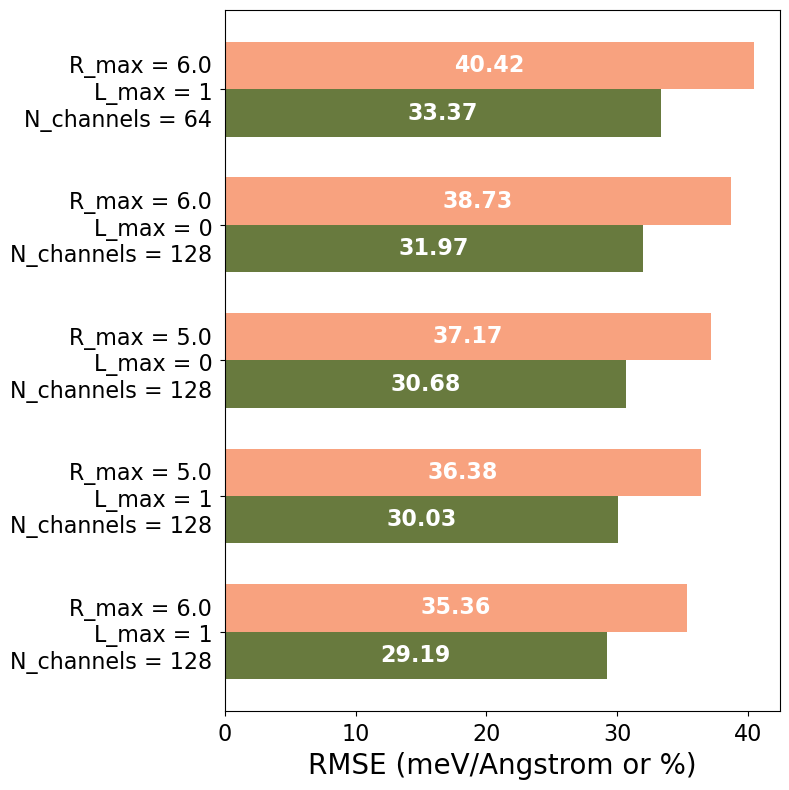

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Get top 5 models by Default_final_rmse_f
top_5 = df.nsmallest(5, 'Default_final_rmse_f')

def create_model_label(model_name):
    # Extract parameters from model name
    r_max = float(model_name.split('r_cut')[1].split('_')[0])
    max_l = int(model_name.split('max_L')[1].split('_')[0])
    num_channels = int(model_name.split('num_channels')[1].split('_')[0])
    return f'R_max = {r_max}\nL_max = {max_l}\nN_channels = {num_channels}'

# Prepare data
labels = [create_model_label(name) for name in top_5['Name']]
rmse_f = top_5['Default_final_rmse_f'].values
rel_rmse_f = top_5['Default_final_rel_rmse_f'].values

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bars
y_pos = np.arange(len(labels))
bar_height = 0.35

# Plot both metrics with specified colors
bars1 = ax.barh(y_pos - bar_height/2, rmse_f, bar_height, 
                label='RMSE_f', color='#687a3e')
bars2 = ax.barh(y_pos + bar_height/2, rel_rmse_f, bar_height,
                label='Relative RMSE_f', color='#f8a27f')

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=16)
ax.set_xlabel('RMSE (meV/Angstrom or %)', fontsize=20)
#ax.set_title('Top 5 Models Performance Comparison', fontsize=16, pad=20)
#ax.legend(fontsize=12)

# Increase font size for x-axis
ax.tick_params(axis='x', labelsize=16)

# Add value labels in the middle of the bars
for bar in bars1:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    ax.text(width/2, y_pos, f'{width:.2f}', 
            ha='center', va='center', fontsize=16, color='white', fontweight='bold')

for bar in bars2:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    ax.text(width/2, y_pos, f'{width:.2f}', 
            ha='center', va='center', fontsize=16, color='white', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_9372/1517425611.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


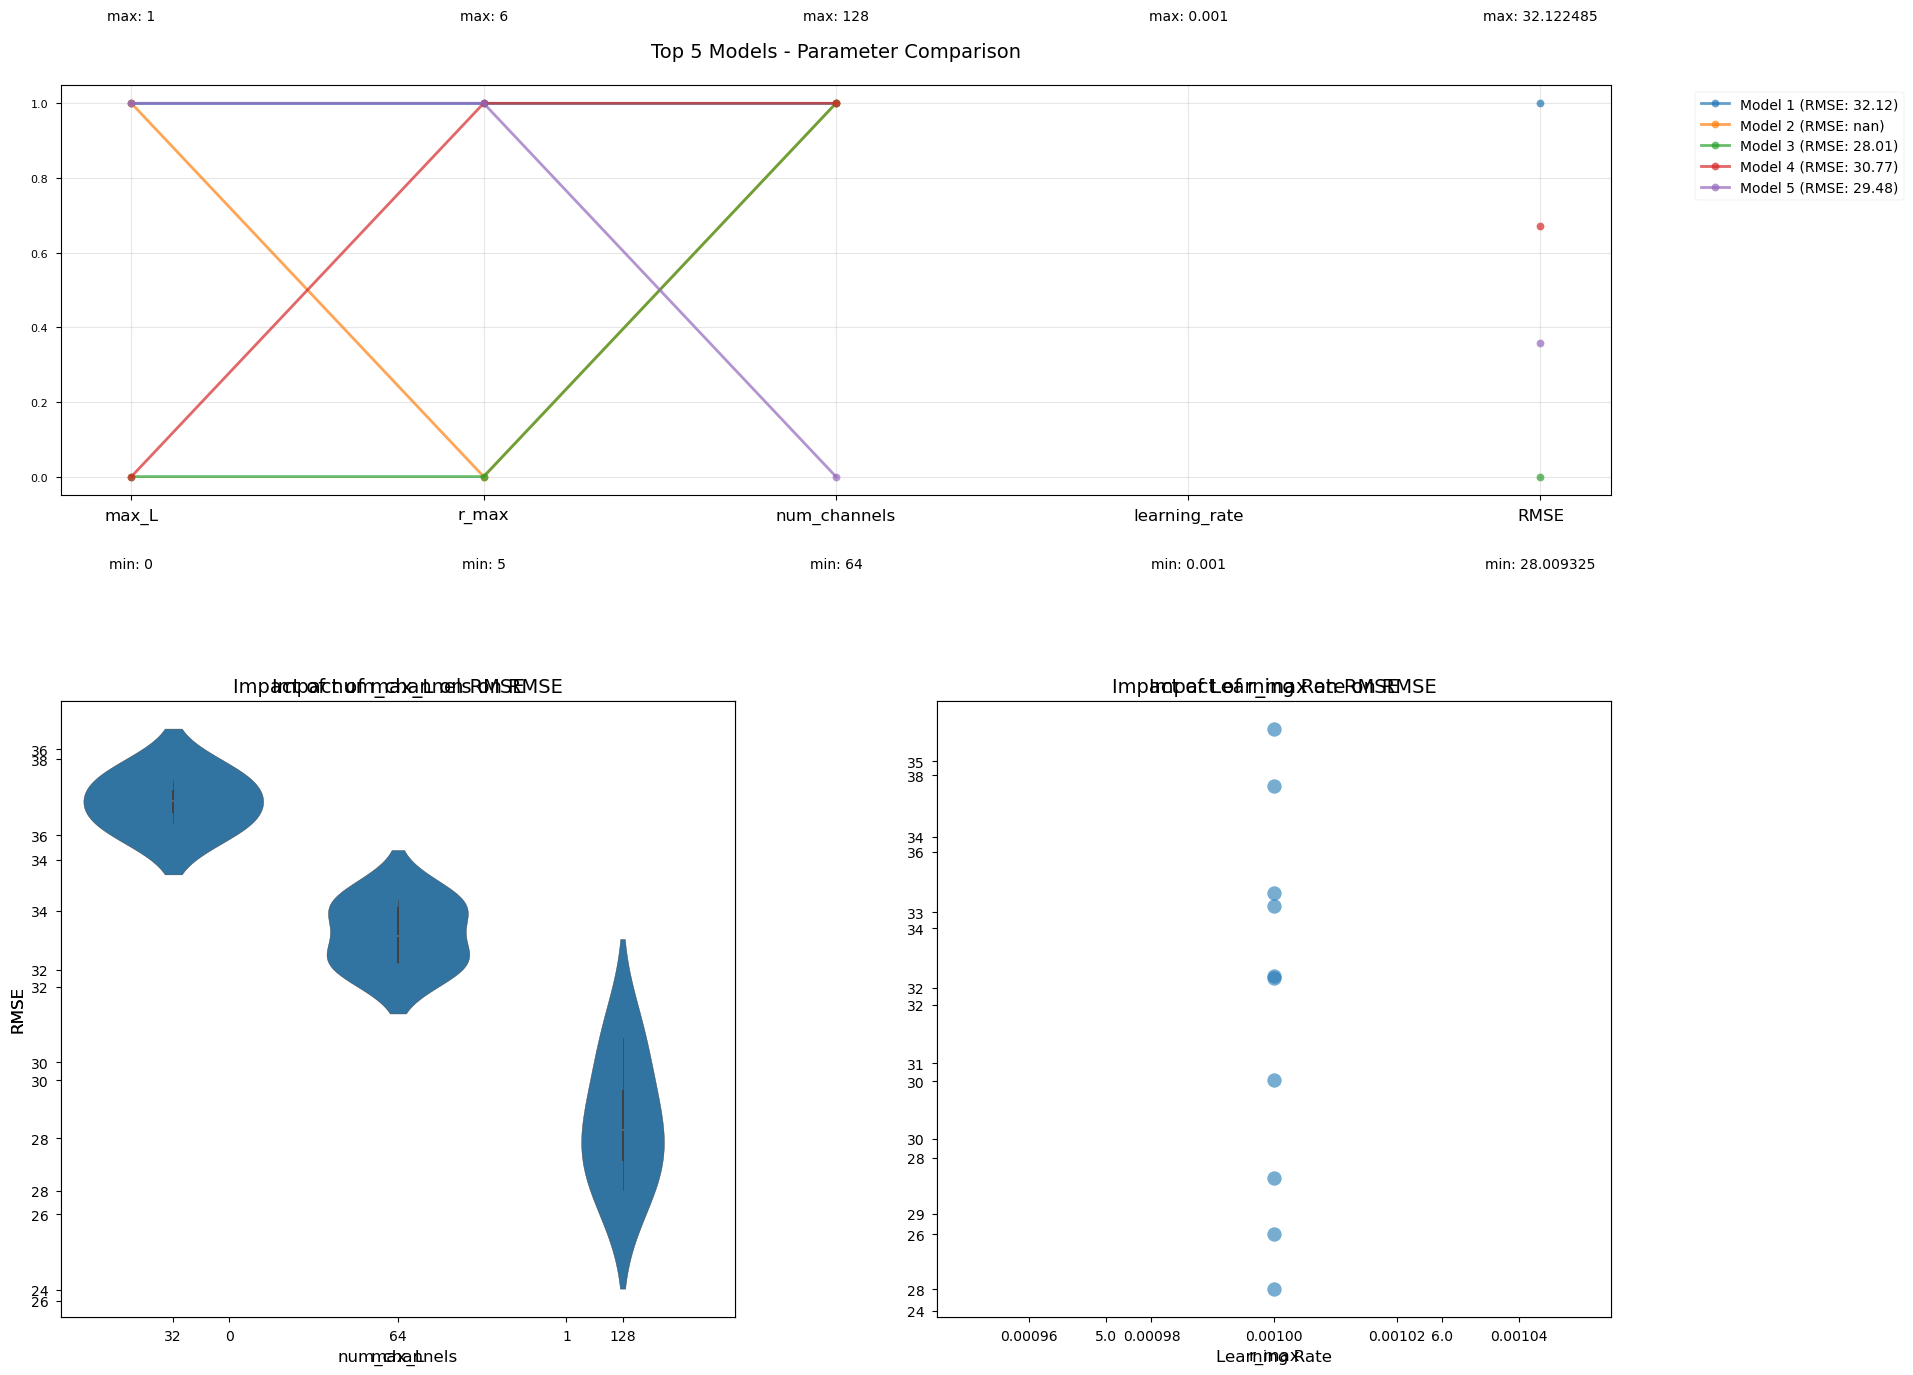

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np

# Function to extract parameters from JSON string
def extract_params(params_str):
    params = json.loads(params_str)
    return {
        'max_L': int(params['name'].split('max_L')[1].split('_')[0]),
        'r_max': float(params['name'].split('r_cut')[1].split('_')[0]),
        'num_channels': int(params['name'].split('num_channels')[1].split('_')[0]),
        'learning_rate': float(params['name'].split('learning_rate')[1].split('_')[0])
    }

# Create figure with subplots
plt.style.use('seaborn-v0_8-paper')
fig = plt.figure(figsize=(20, 16))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1.5], hspace=0.4, wspace=0.3)

# Top plot: Best models comparison
ax1 = fig.add_subplot(gs[0, :])

# Sort by RMSE and get top 5
df_sorted = df.sort_values('valid_final_rmse_f')
top_5 = df_sorted.head(5)

# Extract parameters for top 5
top_5_params = pd.DataFrame([extract_params(row['params']) for _, row in top_5.iterrows()])
top_5_params['RMSE'] = top_5['valid_final_rmse_f']

# Create parallel coordinates for top 5
param_columns = ['max_L', 'r_max', 'num_channels', 'learning_rate', 'RMSE']
param_ranges = {col: (top_5_params[col].min(), top_5_params[col].max()) for col in param_columns}

# Normalize the data for parallel coordinates
normalized_data = pd.DataFrame()
for col in param_columns:
    min_val, max_val = param_ranges[col]
    normalized_data[col] = (top_5_params[col] - min_val) / (max_val - min_val)

# Plot parallel coordinates for top 5 models with different colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in range(len(normalized_data)):
    ax1.plot(range(len(param_columns)), normalized_data.iloc[i], '-o', 
             color=colors[i], alpha=0.7, linewidth=2, 
             label=f'Model {i+1} (RMSE: {top_5_params.iloc[i]["RMSE"]:.2f})')

ax1.set_xticks(range(len(param_columns)))
ax1.set_xticklabels(param_columns, fontsize=12)
ax1.set_title('Top 5 Models - Parameter Comparison', fontsize=14, pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add original values as annotations with more spacing
for i, col in enumerate(param_columns):
    y_pos = -0.15
    ax1.text(i, y_pos, f'min: {param_ranges[col][0]:.6f}'.rstrip('0').rstrip('.'),
             ha='center', va='top', transform=ax1.get_xaxis_transform(), fontsize=10)
    ax1.text(i, 1.15, f'max: {param_ranges[col][1]:.6f}'.rstrip('0').rstrip('.'),
             ha='center', va='bottom', transform=ax1.get_xaxis_transform(), fontsize=10)

# Bottom plots: Parameter impact plots
all_params = pd.DataFrame([extract_params(row['params']) for _, row in df.iterrows()])
all_params['RMSE'] = df['valid_final_rmse_f']

# Create violin plots for discrete parameters
param_names = ['max_L', 'r_max', 'num_channels']
for idx, param in enumerate(param_names):
    ax = fig.add_subplot(gs[1, idx % 2])
    sns.violinplot(data=all_params, x=param, y='RMSE', ax=ax)
    ax.set_title(f'Impact of {param} on RMSE', fontsize=14)
    ax.set_xlabel(param, fontsize=12)
    ax.set_ylabel('RMSE' if idx % 2 == 0 else '', fontsize=12)
    ax.tick_params(labelsize=10)
    
# Add learning rate scatter plot
ax = fig.add_subplot(gs[1, -1])
ax.scatter(all_params['learning_rate'], all_params['RMSE'], alpha=0.6, s=100)
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title('Impact of Learning Rate on RMSE', fontsize=14)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

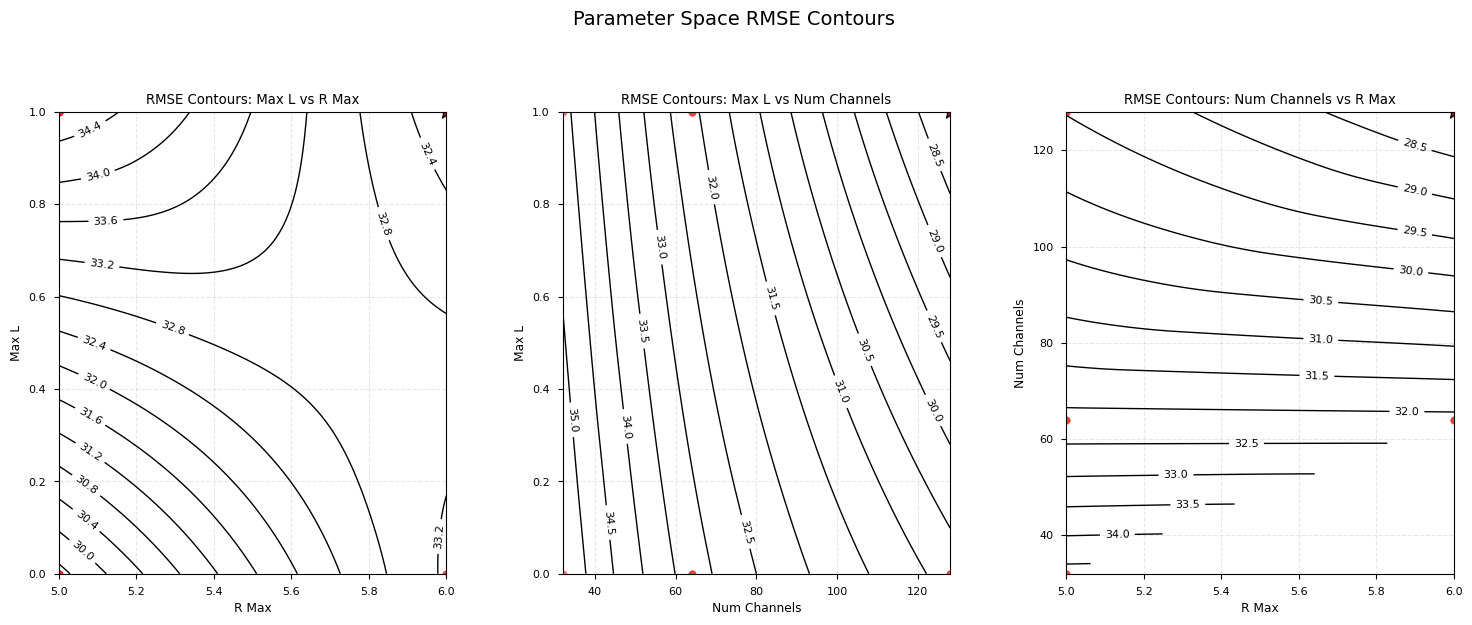


Optimal parameters:
max_L: 1
r_max: 6.0
num_channels: 128
RMSE: 28.0093


In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import json

# Function to extract parameters
def extract_params(params_str):
    params = json.loads(params_str)
    return {
        'max_L': int(params['name'].split('max_L')[1].split('_')[0]),
        'r_max': float(params['name'].split('r_cut')[1].split('_')[0]),
        'num_channels': int(params['name'].split('num_channels')[1].split('_')[0])
    }

# Extract parameters and RMSE
all_params = pd.DataFrame([extract_params(row['params']) for _, row in df.iterrows()])
all_params['RMSE'] = df['valid_final_rmse_f']

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

# Parameter pairs to plot
param_pairs = [
    ('r_max', 'max_L'),
    ('num_channels', 'max_L'),
    ('r_max', 'num_channels')
]

for idx, (param1, param2) in enumerate(param_pairs):
    ax = axs[idx]
    
    x = all_params[param1].values
    y = all_params[param2].values
    z = all_params['RMSE'].values
    
    # Create regular grid
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create contour plot with only lines
    contour = ax.contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
    
    # Plot data points
    scatter = ax.scatter(x, y, c='red', s=30, alpha=0.5)
    
    # Mark minimum point
    min_idx = np.argmin(z)
    ax.scatter(x[min_idx], y[min_idx], c='red', s=100, marker='*', 
              edgecolor='black', linewidth=1)
    
    # Labels
    ax.set_xlabel(param1.replace('_', ' ').title())
    ax.set_ylabel(param2.replace('_', ' ').title())
    ax.set_title(f'RMSE Contours: {param2.replace("_", " ").title()} vs {param1.replace("_", " ").title()}')
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Parameter Space RMSE Contours', fontsize=14, y=1.05)
plt.show()

# Print best parameters
best_idx = all_params['RMSE'].idxmin()
print("\nOptimal parameters:")
for col in ['max_L', 'r_max', 'num_channels']:
    print(f"{col}: {all_params.loc[best_idx, col]}")
print(f"RMSE: {all_params.loc[best_idx, 'RMSE']:.4f}")

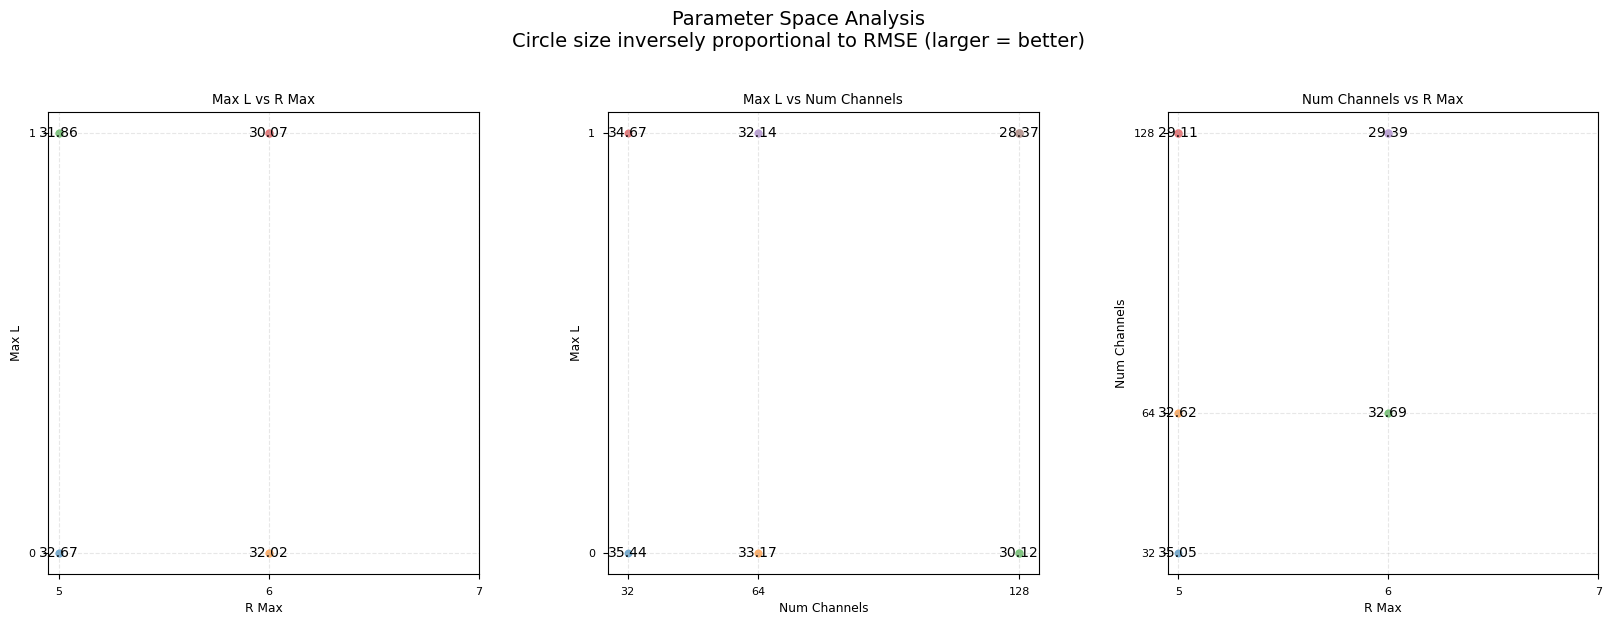


Optimal parameters:
max_L: 1
r_max: 6.0
num_channels: 128
RMSE: 28.0093


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

# Function to extract parameters
def extract_params(params_str):
    params = json.loads(params_str)
    return {
        'max_L': int(params['name'].split('max_L')[1].split('_')[0]),
        'r_max': float(params['name'].split('r_cut')[1].split('_')[0]),
        'num_channels': int(params['name'].split('num_channels')[1].split('_')[0])
    }

# Extract parameters and RMSE
all_params = pd.DataFrame([extract_params(row['params']) for _, row in df.iterrows()])
all_params['RMSE'] = df['valid_final_rmse_f']

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# Parameter pairs to plot
param_pairs = [
    ('r_max', 'max_L'),
    ('num_channels', 'max_L'),
    ('r_max', 'num_channels')
]

for idx, (param1, param2) in enumerate(param_pairs):
    ax = axs[idx]
    
    # Group by the two parameters and get mean RMSE
    pivot = pd.pivot_table(all_params, 
                          values='RMSE', 
                          index=param2,
                          columns=param1,
                          aggfunc='mean')
    
    # Plot as a scatter with sizes proportional to RMSE
    for y_val in pivot.index:
        for x_val in pivot.columns:
            rmse = pivot.loc[y_val, x_val]
            if not np.isnan(rmse):  # Only plot if we have data for this combination
                size = 1000 * (1 / rmse)  # Larger circles for lower RMSE
                ax.scatter(x_val, y_val, s=size, alpha=0.6, 
                          label=f'RMSE: {rmse:.2f}')
                ax.text(x_val, y_val, f'{rmse:.2f}', 
                       ha='center', va='center', fontsize=10)
    
    # Set proper ticks
    if param1 == 'num_channels':
        ax.set_xticks([32, 64, 128])
    elif param1 == 'r_max':
        ax.set_xticks([5, 6, 7])
    else:
        ax.set_xticks([0, 1])
        
    if param2 == 'num_channels':
        ax.set_yticks([32, 64, 128])
    elif param2 == 'r_max':
        ax.set_yticks([5, 6, 7])
    else:
        ax.set_yticks([0, 1])
    
    # Labels
    ax.set_xlabel(param1.replace('_', ' ').title())
    ax.set_ylabel(param2.replace('_', ' ').title())
    ax.set_title(f'{param2.replace("_", " ").title()} vs {param1.replace("_", " ").title()}')
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Parameter Space Analysis\nCircle size inversely proportional to RMSE (larger = better)', 
             fontsize=14, y=1.05)
plt.show()

# Print best parameters
best_idx = all_params['RMSE'].idxmin()
print("\nOptimal parameters:")
for col in ['max_L', 'r_max', 'num_channels']:
    print(f"{col}: {all_params.loc[best_idx, col]}")
print(f"RMSE: {all_params.loc[best_idx, 'RMSE']:.4f}")